In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product as outer

%matplotlib inline

# Load Data

In [2]:
data = pd.read_csv("tmuris.coverage.partial.tsv.gz", sep='\t',
                   dtype={'chromosom': 'category', 'batch': 'category', 'gene': 'category'})
data.head()

,chromosome,position,counts,batch,gene,txEnd,width,distance
0,chr2,91278316,1,SRR6835844,1110051M20Rik,91278241,711,75
1,chr2,91278318,1,SRR6835844,1110051M20Rik,91278241,711,77
2,chr2,91278323,1,SRR6835844,1110051M20Rik,91278241,711,82
3,chr2,91278324,1,SRR6835844,1110051M20Rik,91278241,711,83
4,chr2,91278328,1,SRR6835844,1110051M20Rik,91278241,711,87


## Util Functions

In [3]:
def weighted_quantile(values, quantiles, weights=None, is_sorted=False, old_style=False):
    """
    A weighted implementation of numpy.percentile.
    
    :param values: np.array with data
    :param quantiles: array-like with values in [0, 1]
    :param weights: array-like of the same length as `array`
    :param sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with np.percentile
    
    :return: np.array with computed quantiles
    
    Credit: https://stackoverflow.com/a/29677616/570918
    """
    if values.size == 0:
        return None
    
    values = np.array(values)
    quantiles = np.array(quantiles)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1)
    
    if weights is None:
        weights = np.ones(len(values))
    weights = np.array(weights)
    
    if not is_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        weights = weights[sorter]

    weighted_quantiles = np.cumsum(weights) - 0.5 * weights
    
    if old_style:
        # To be convenient with np.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(weights)
    
    return np.interp(quantiles, weighted_quantiles, values)

# Compute Stats

In [4]:
cutoff95_bg = data.groupby(['batch', 'gene']).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))
cutoff95_bg.head()

batch       gene         
SRR6835844  1110051M20Rik    384.900000
            Acaca            397.675000
            Agl              932.400000
            Aplp2            379.740541
            Arfgef1          382.783333
dtype: float64

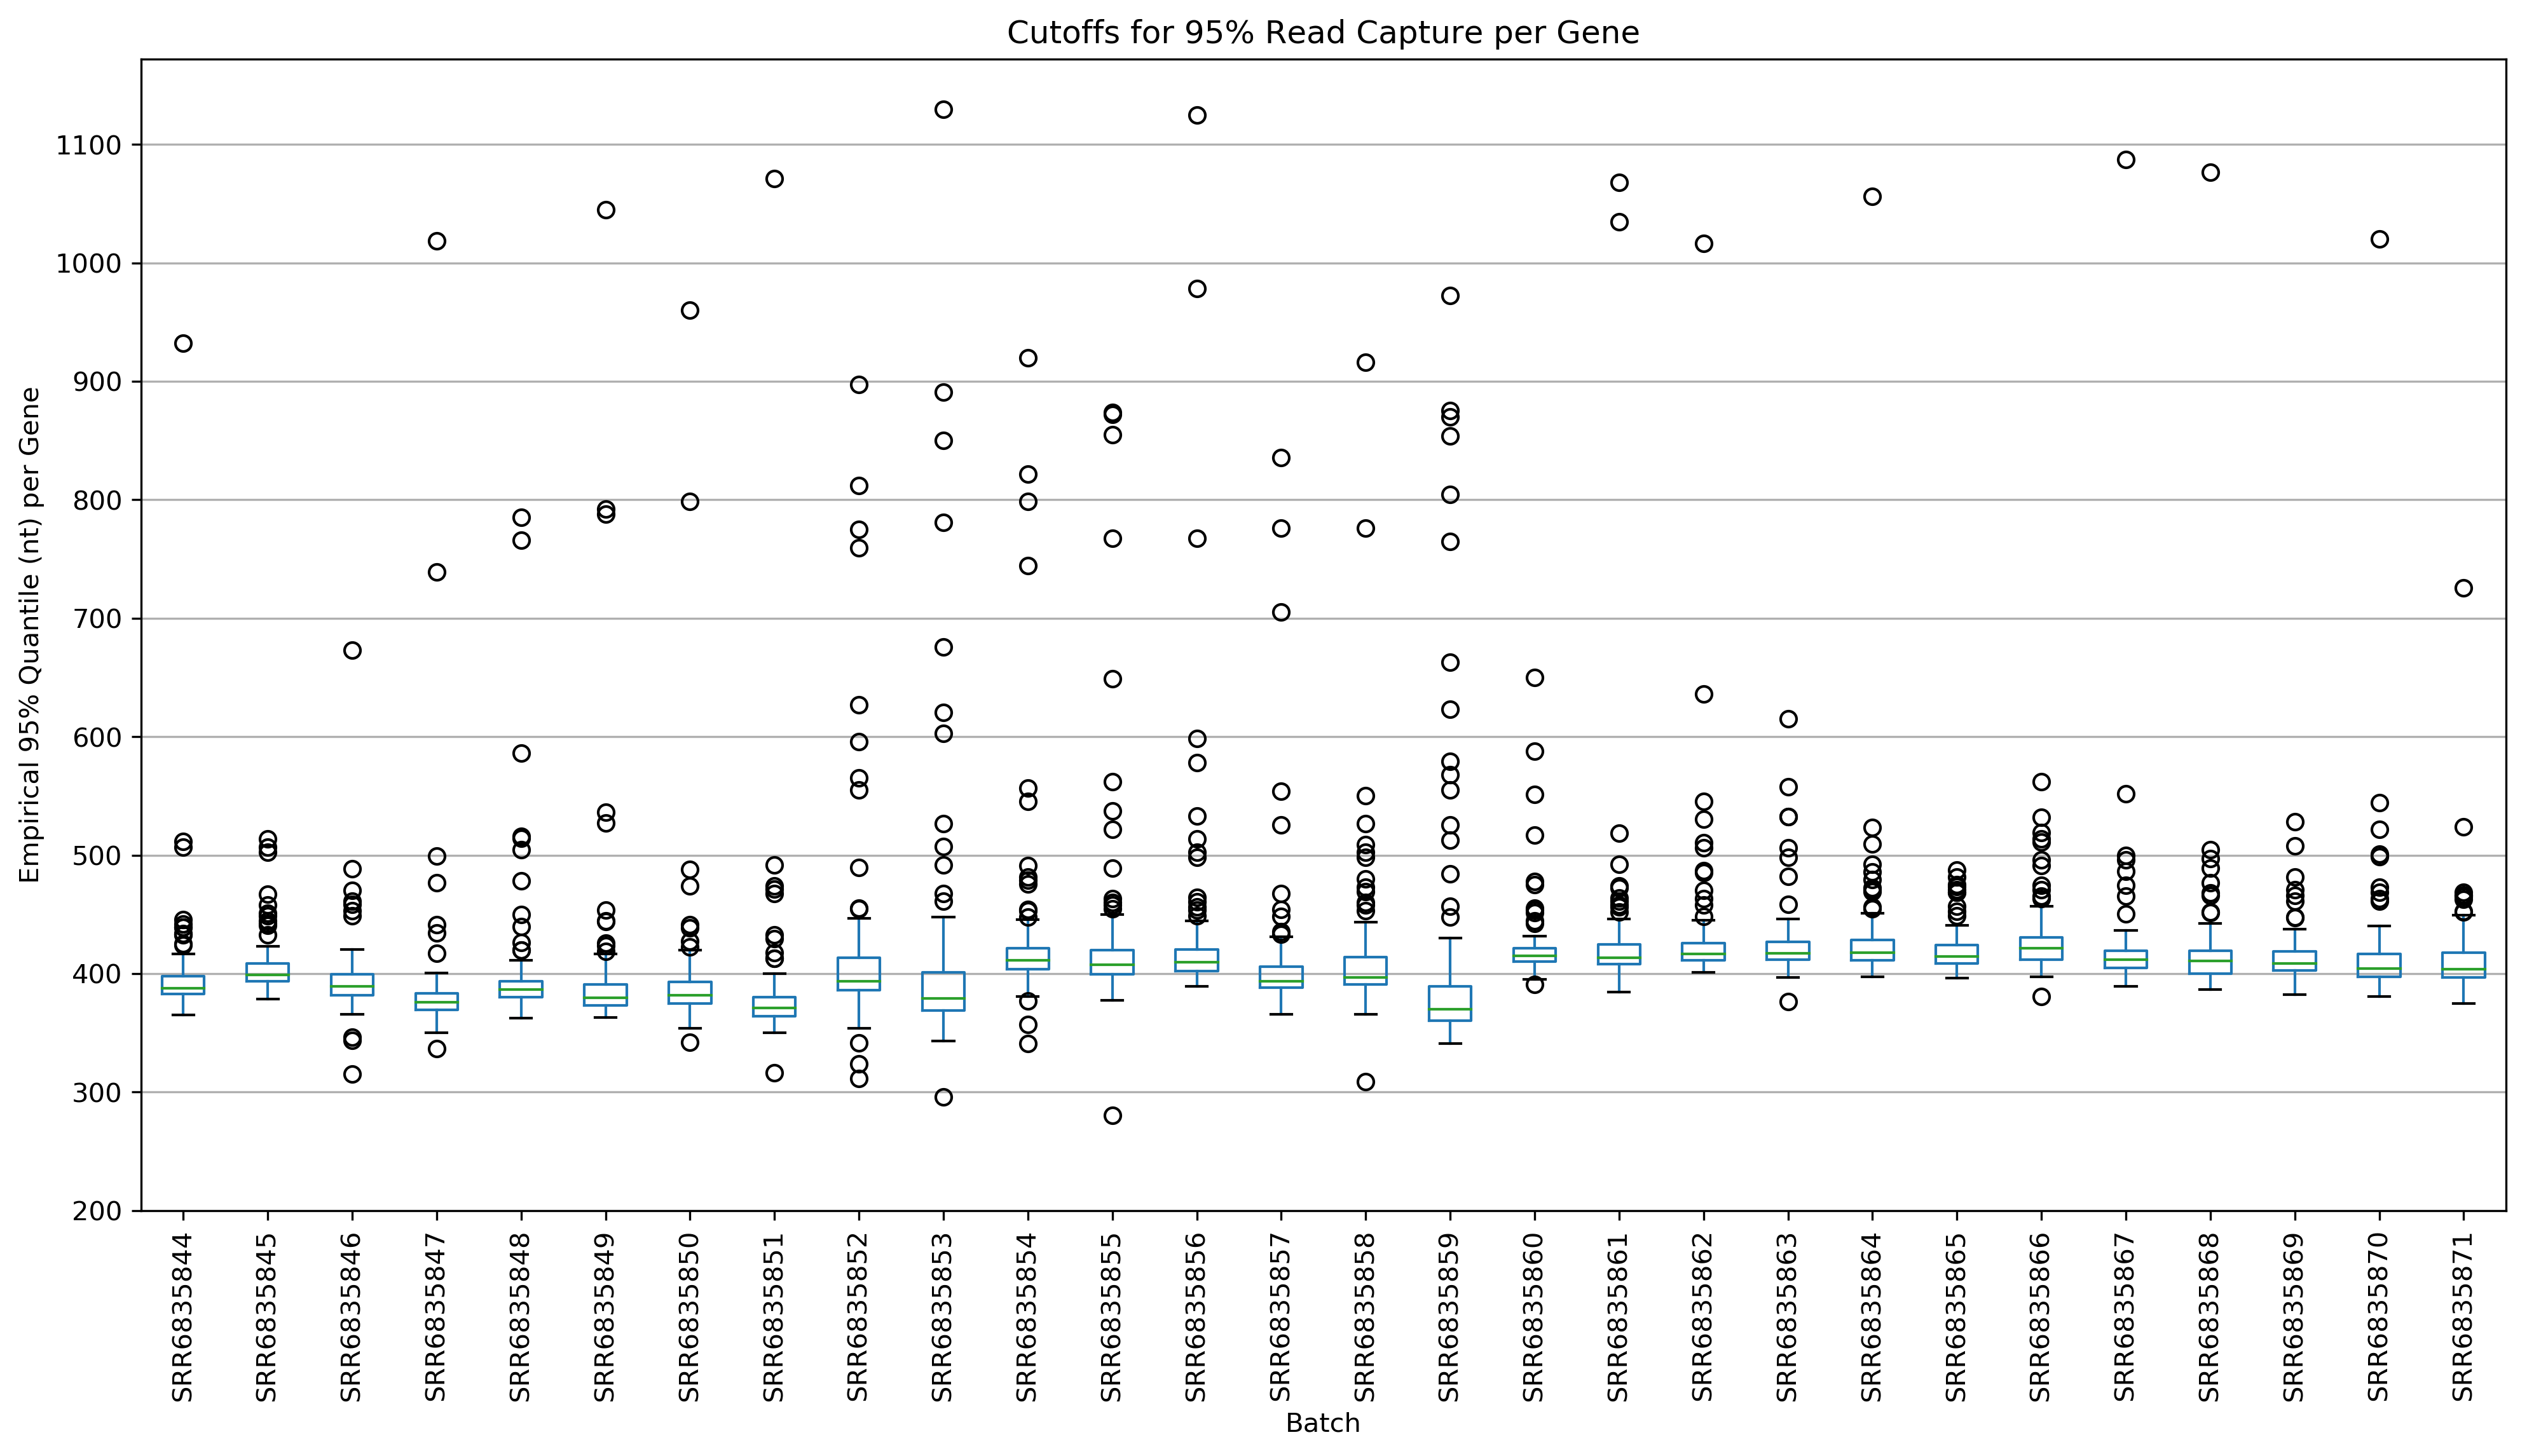

In [5]:
ax = cutoff95_bg.unstack(level=0).plot(kind='box', figsize=(16,8), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,1200,100))
plt.grid(True, axis='y')

plt.title("Cutoffs for 95% Read Capture per Gene")
plt.ylabel("Empirical 95% Quantile (nt) per Gene")
plt.xlabel("Batch")
plt.show()

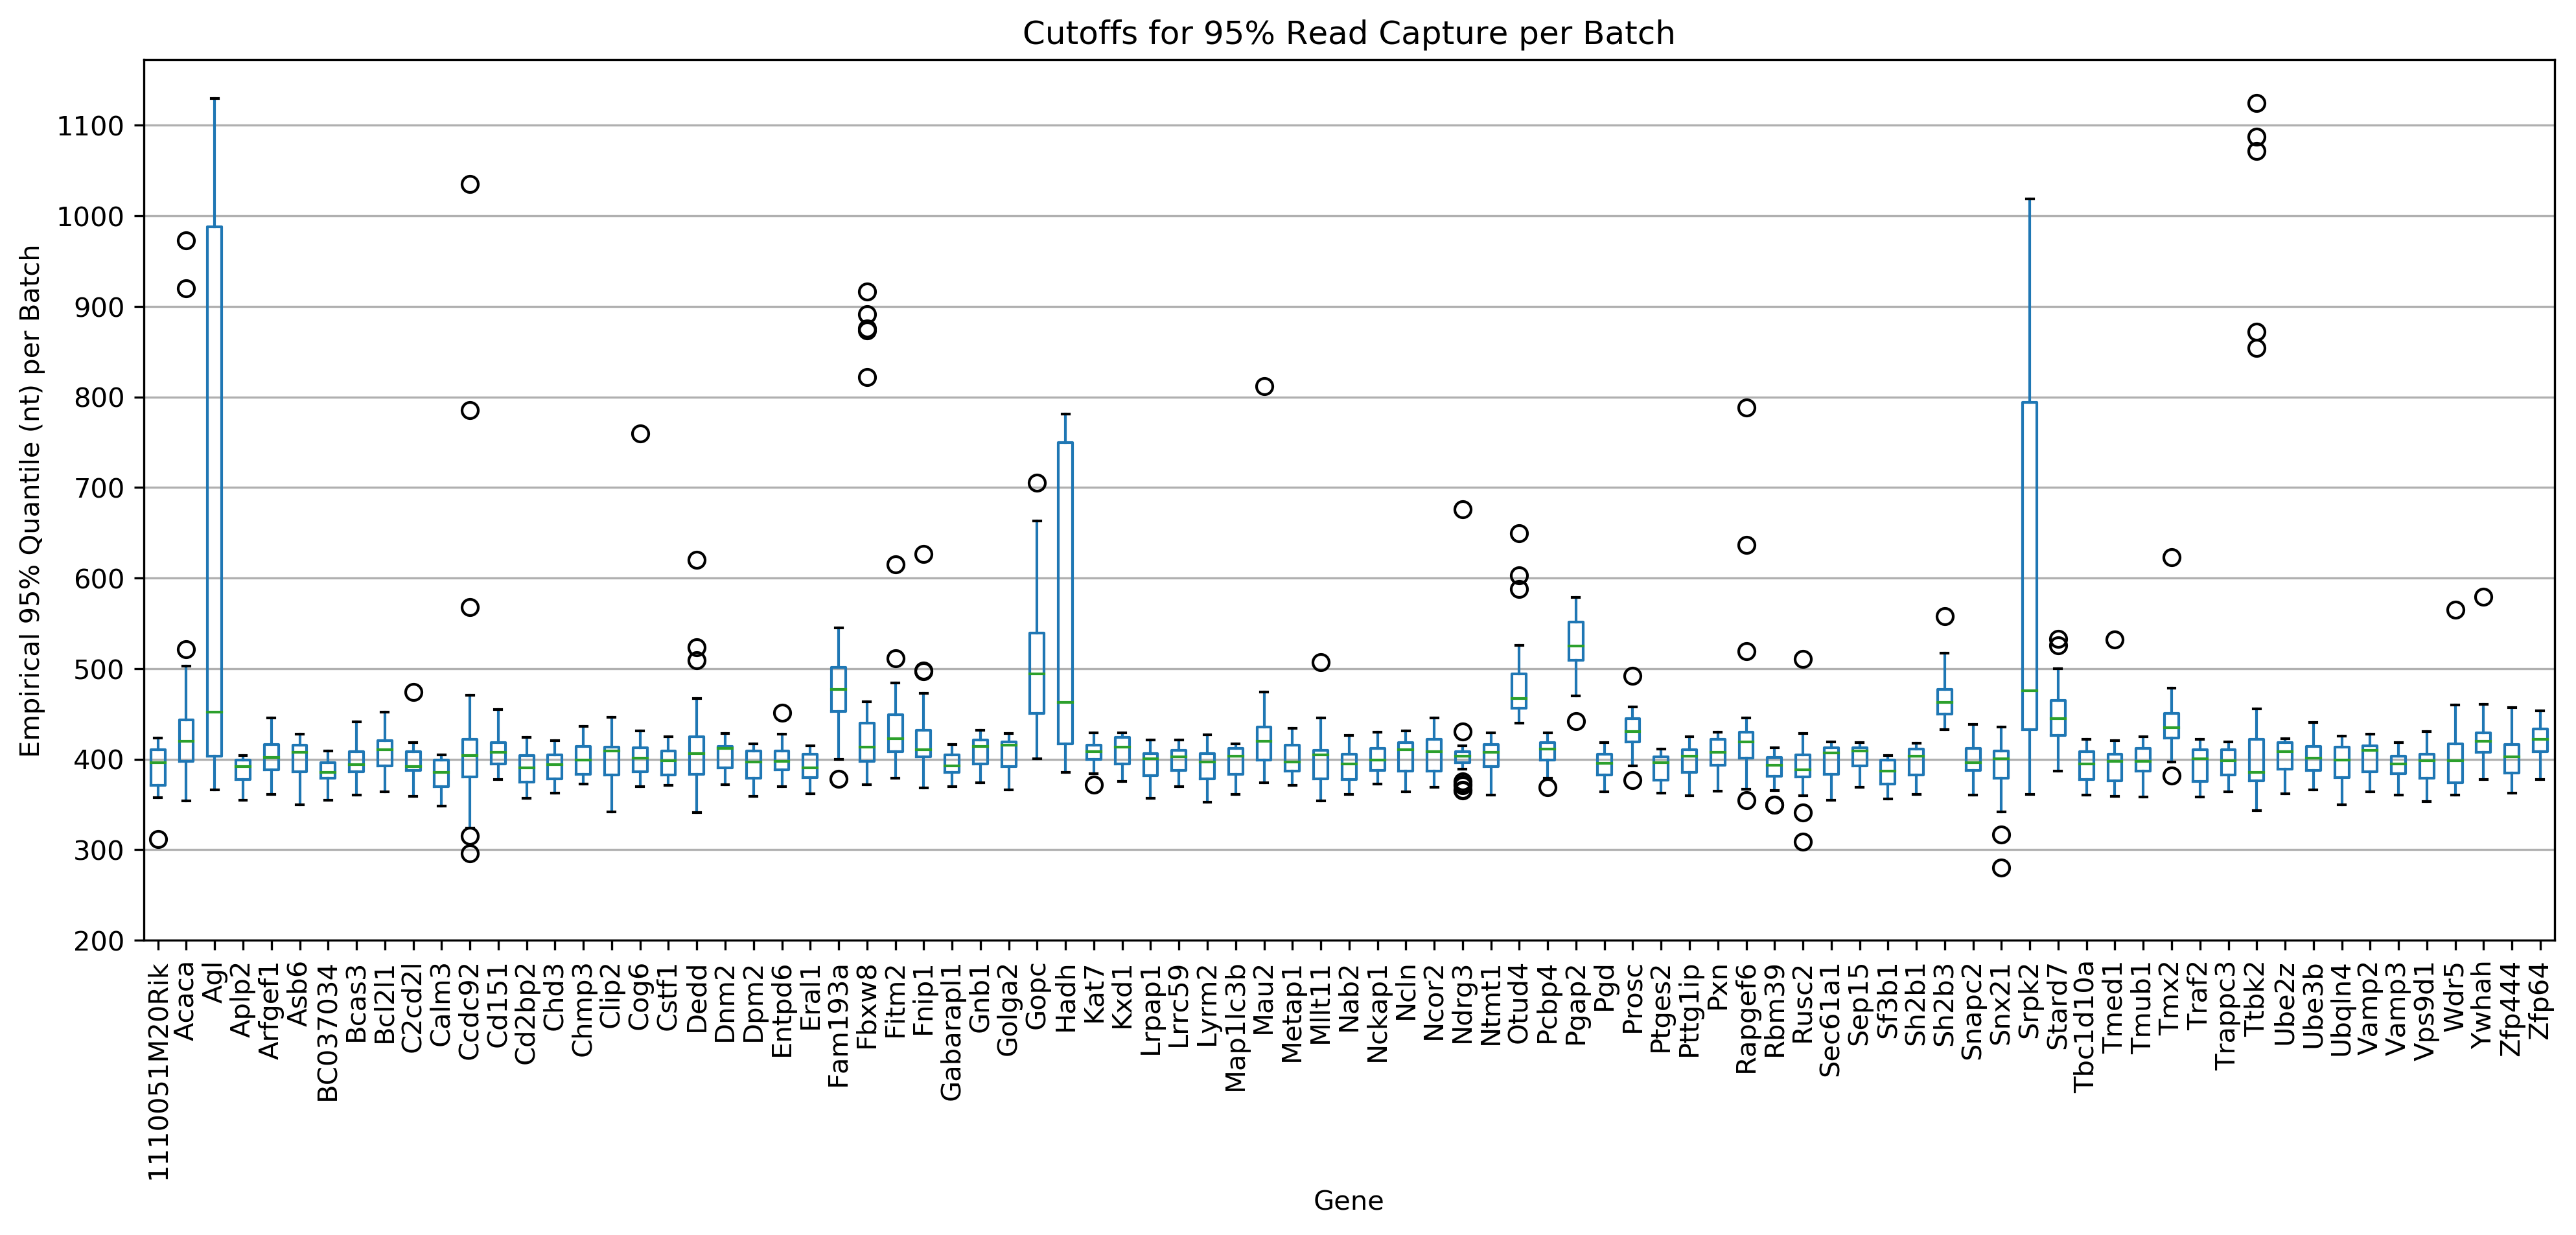

In [6]:
ax = cutoff95_bg.unstack(level=-1).plot(kind='box', figsize=(16,6), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,1200,100))
plt.grid(True, axis='y')
plt.title("Cutoffs for 95% Read Capture per Batch")
plt.ylabel("Empirical 95% Quantile (nt) per Batch")
plt.xlabel("Gene")
plt.show()

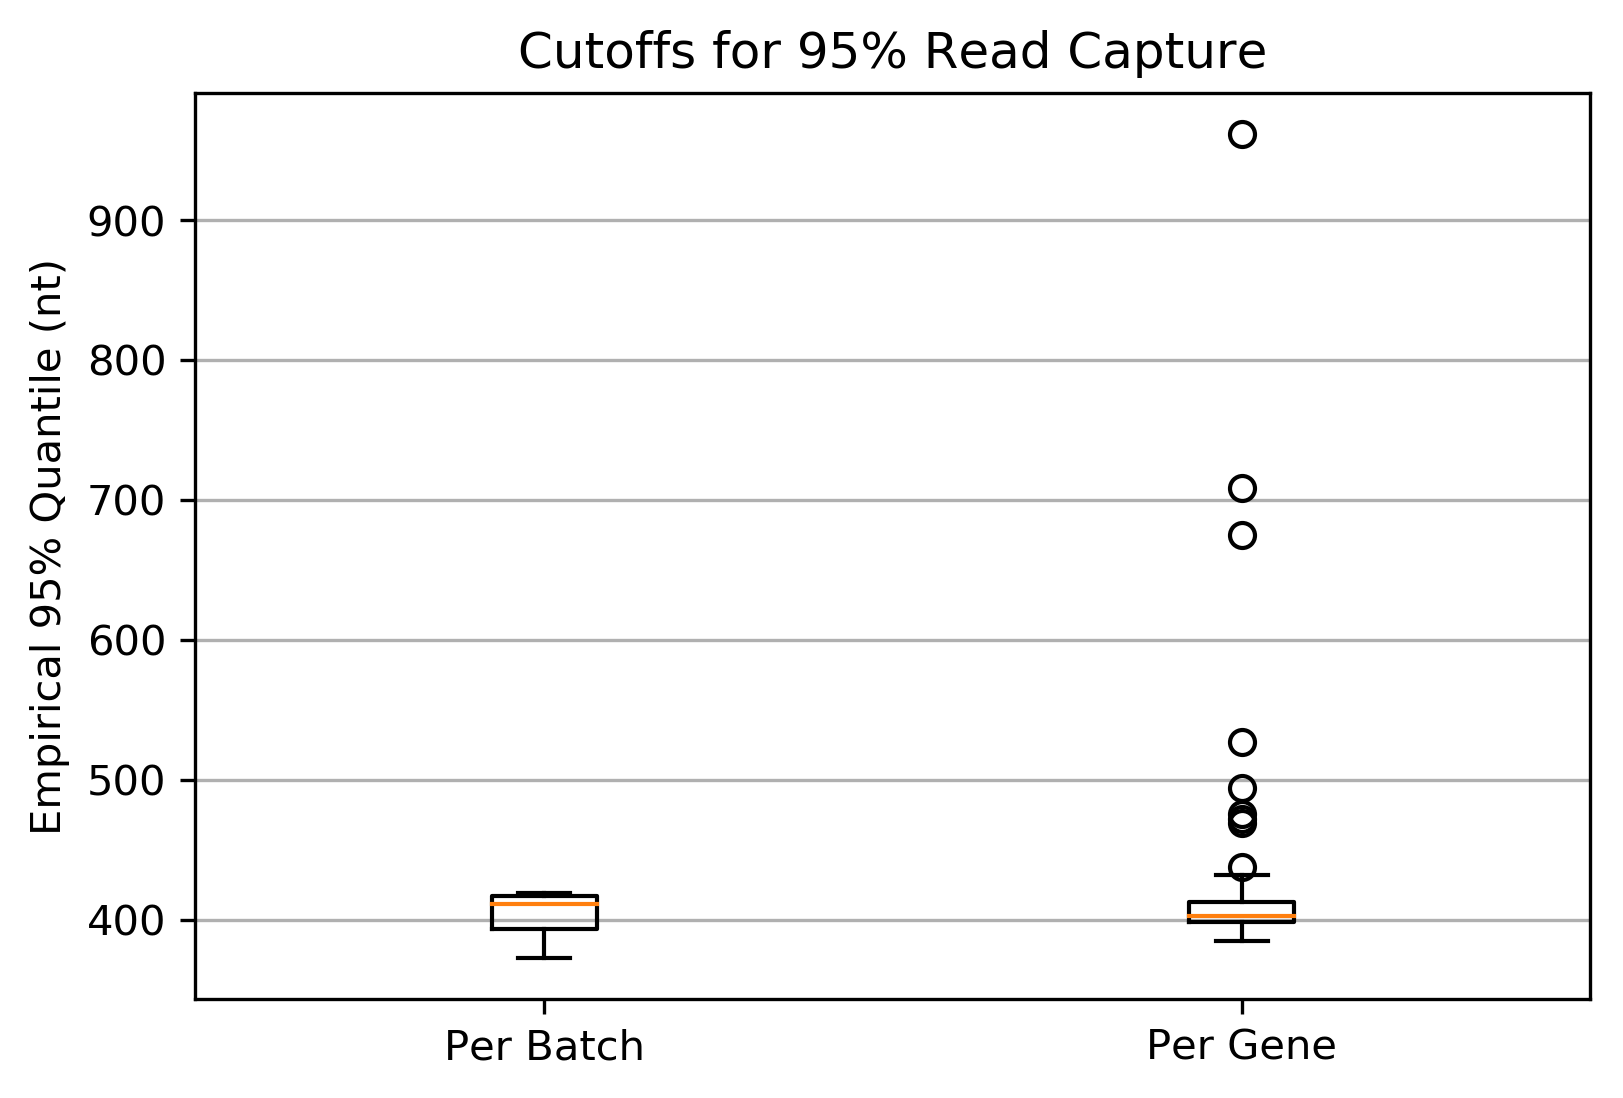

In [7]:
cutoff95_b = data.groupby(['batch']).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))
cutoff95_g = data.groupby(['gene']).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))

plt.figure(figsize=(6,4), dpi=300)
plt.boxplot([cutoff95_b, cutoff95_g], labels=['Per Batch', 'Per Gene'])
plt.grid(True, axis='y')
plt.title("Cutoffs for 95% Read Capture")
plt.ylabel("Empirical 95% Quantile (nt)")
plt.show()

In [8]:
cutoff95_g.sort_values(ascending=False).head(20)

gene
Agl        961.750000
Hadh       709.000000
Srpk2      675.000000
Pgap2      527.000000
Gopc       494.000000
Fam193a    476.000000
Sh2b3      472.000000
Otud4      469.000000
Stard7     438.000000
Tmx2       432.000000
Prosc      431.000000
Fitm2      428.000000
Zfp64      427.966667
Mau2       420.000000
Ywhah      419.000000
Gnb1       417.000000
Rapgef6    417.000000
Acaca      416.375000
Ccdc92     415.000000
Fnip1      414.000000
dtype: float64

In [9]:
cutoff95_b.sort_values(ascending=False)

batch
SRR6835866    419.000000
SRR6835862    419.000000
SRR6835860    418.248466
SRR6835864    418.000000
SRR6835854    418.000000
SRR6835863    417.000000
SRR6835856    417.000000
SRR6835852    417.000000
SRR6835865    417.000000
SRR6835861    415.000000
SRR6835855    414.000000
SRR6835853    413.000000
SRR6835867    411.000000
SRR6835868    411.000000
SRR6835869    411.000000
SRR6835858    409.000000
SRR6835871    406.000000
SRR6835857    406.000000
SRR6835870    406.000000
SRR6835845    402.000000
SRR6835846    394.000000
SRR6835844    391.000000
SRR6835848    386.000000
SRR6835849    385.000000
SRR6835850    384.000000
SRR6835847    378.000000
SRR6835859    377.000000
SRR6835851    373.000000
dtype: float64

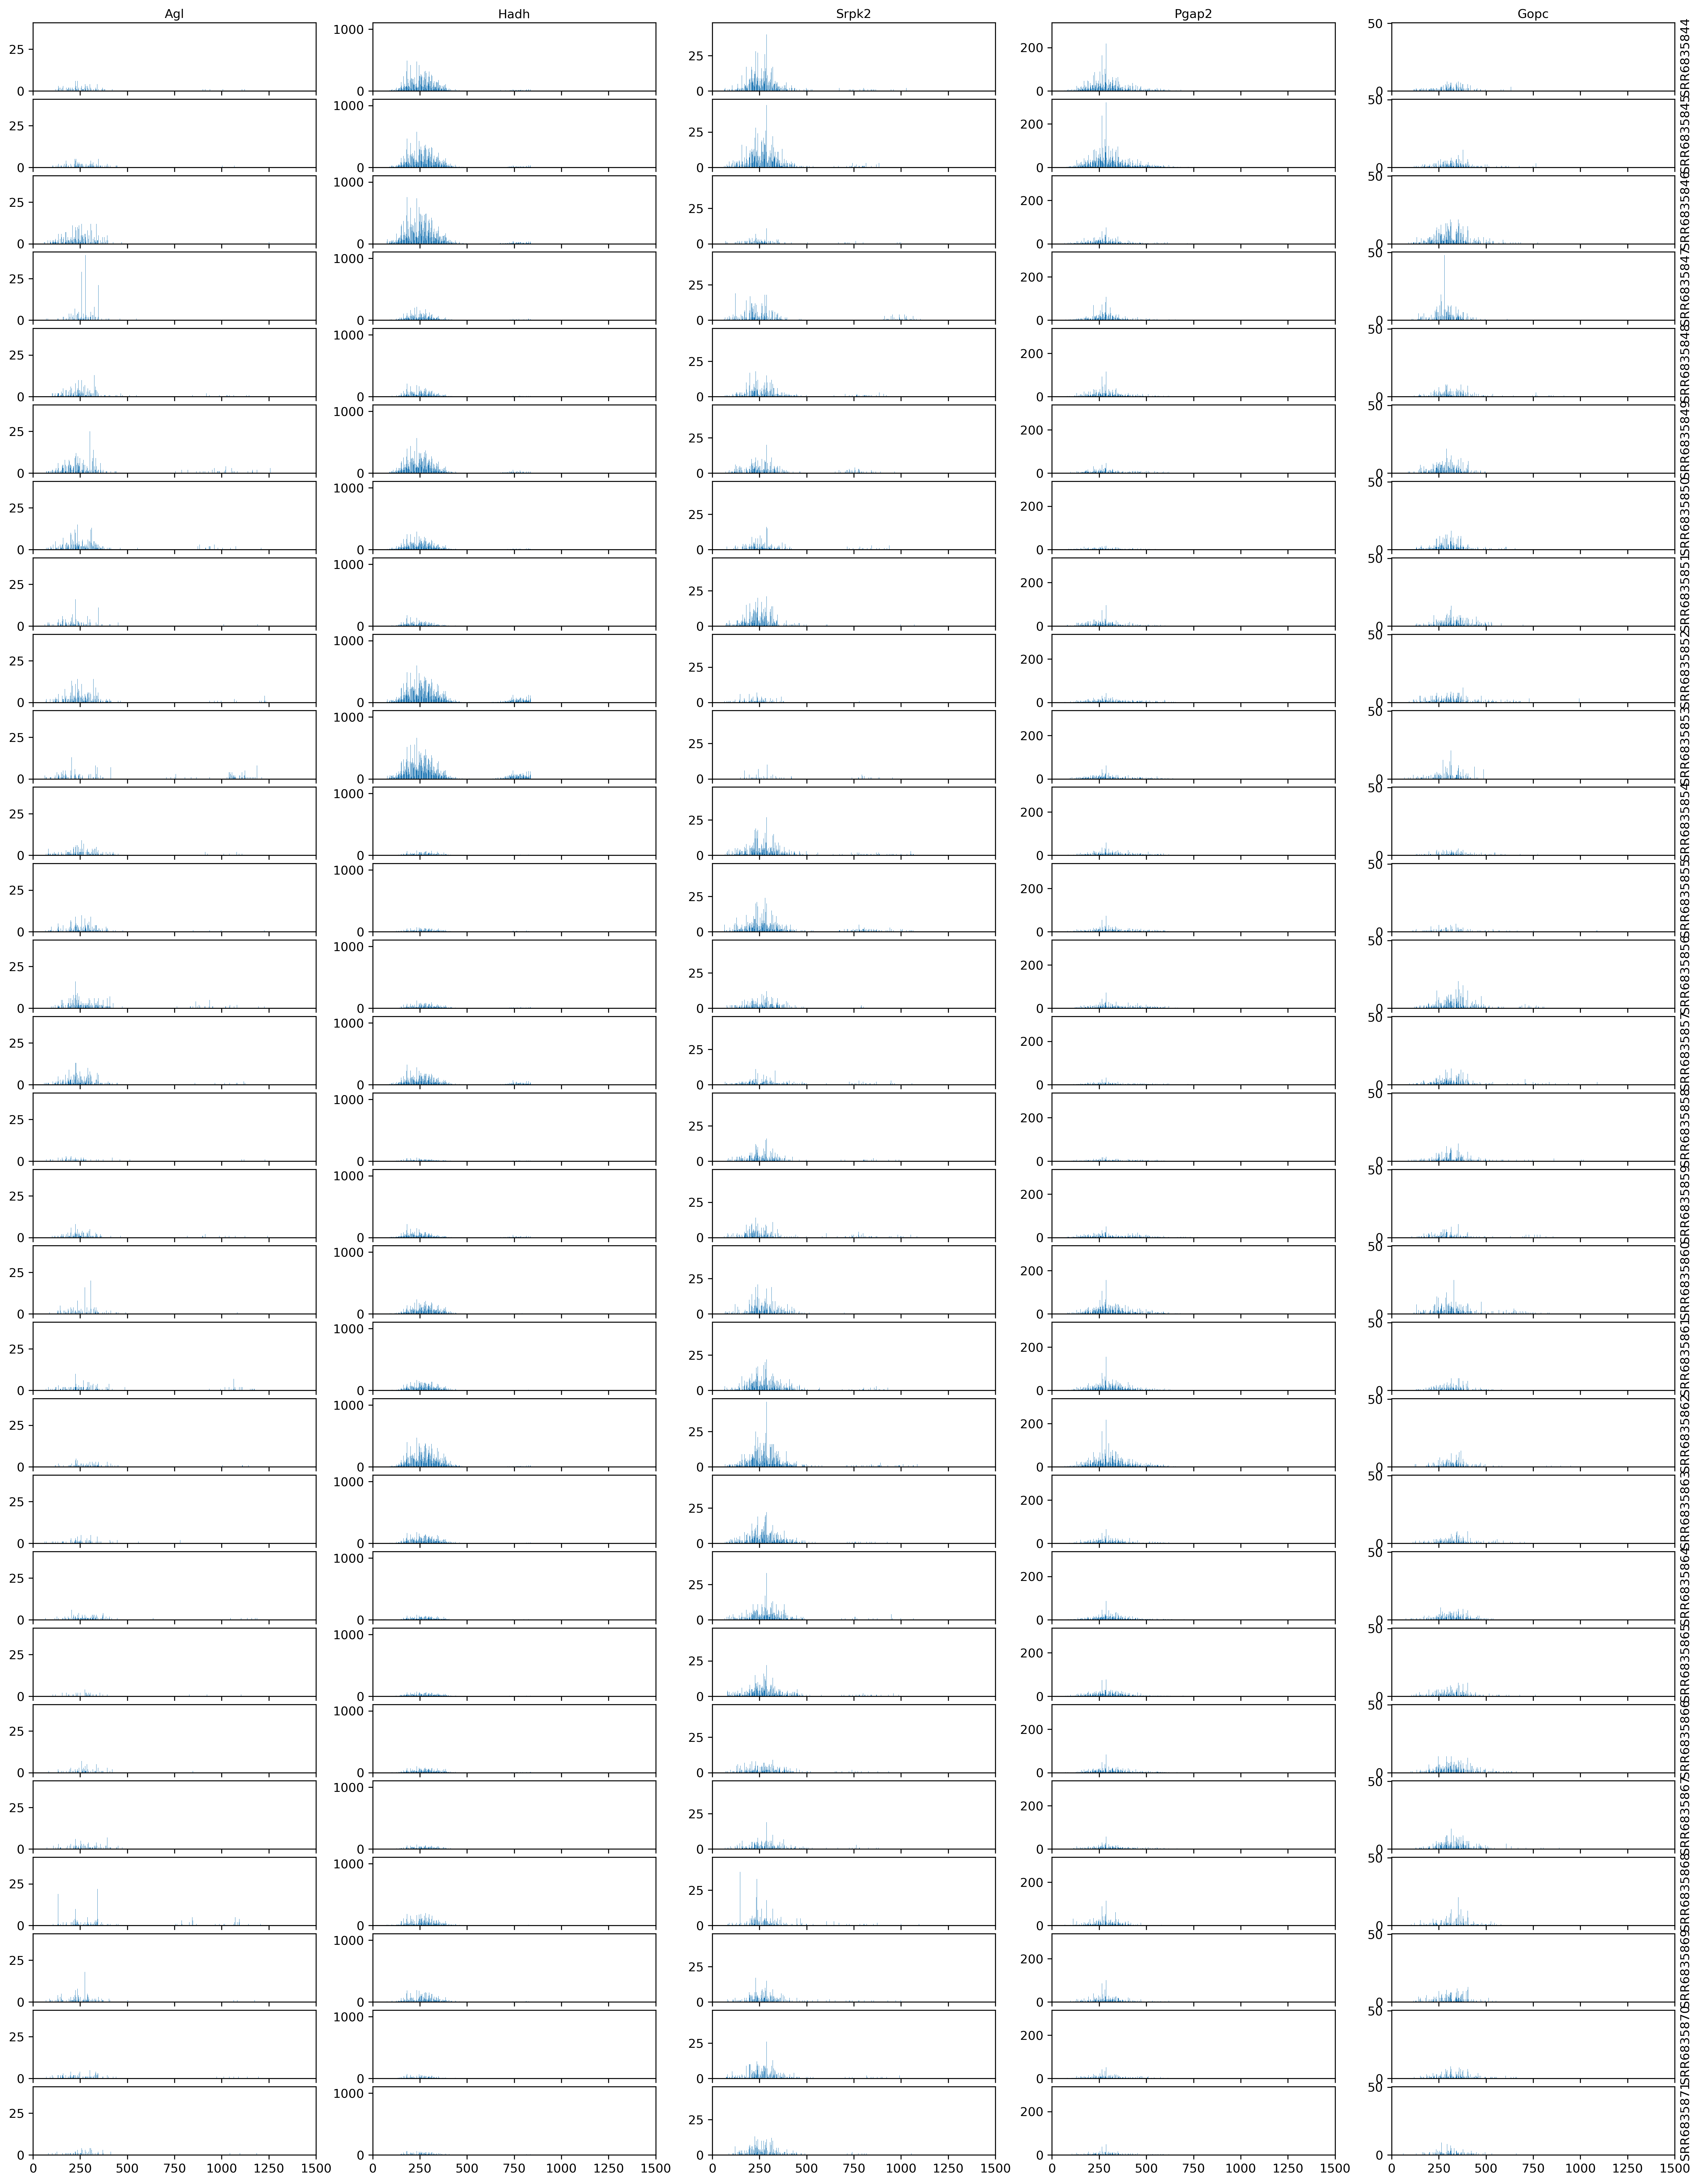

In [10]:
genes = ['Agl', 'Hadh', 'Srpk2', 'Pgap2', 'Gopc']
batches = data.batch.unique()
B, G = len(batches), len(genes)

f, axs = plt.subplots(B, G, figsize=(24, 32), sharex='all', sharey='col')
f.set_dpi(300)
axs[0,0].set_xlim(left=0, right=1500)

for (i,j) in outer(range(B), range(G)):
    b, g = batches[i], genes[j]
    d_gb = data.loc[(data.gene == g) & (data.batch == b), :]
    axs[i, j].bar(x=d_gb.distance, height=d_gb.counts)
    if i == 0:
        axs[i,j].set(xlabel=g)
        axs[i,j].xaxis.set_label_position("top")

    if j == G - 1:
        axs[i,j].set(ylabel=b)
        axs[i,j].yaxis.set_label_position("right")

f.subplots_adjust(hspace=0.12)
plt.show()

In [11]:
data_summary = data.loc[:,['gene', 'distance', 'counts']].groupby(by=['gene', 'distance'], as_index=False).sum()
data_summary.dropna(inplace=True)
data_summary.head()

,gene,distance,counts
1,1110051M20Rik,59,4.0
2,1110051M20Rik,60,1.0
3,1110051M20Rik,61,6.0
4,1110051M20Rik,62,4.0
6,1110051M20Rik,64,2.0


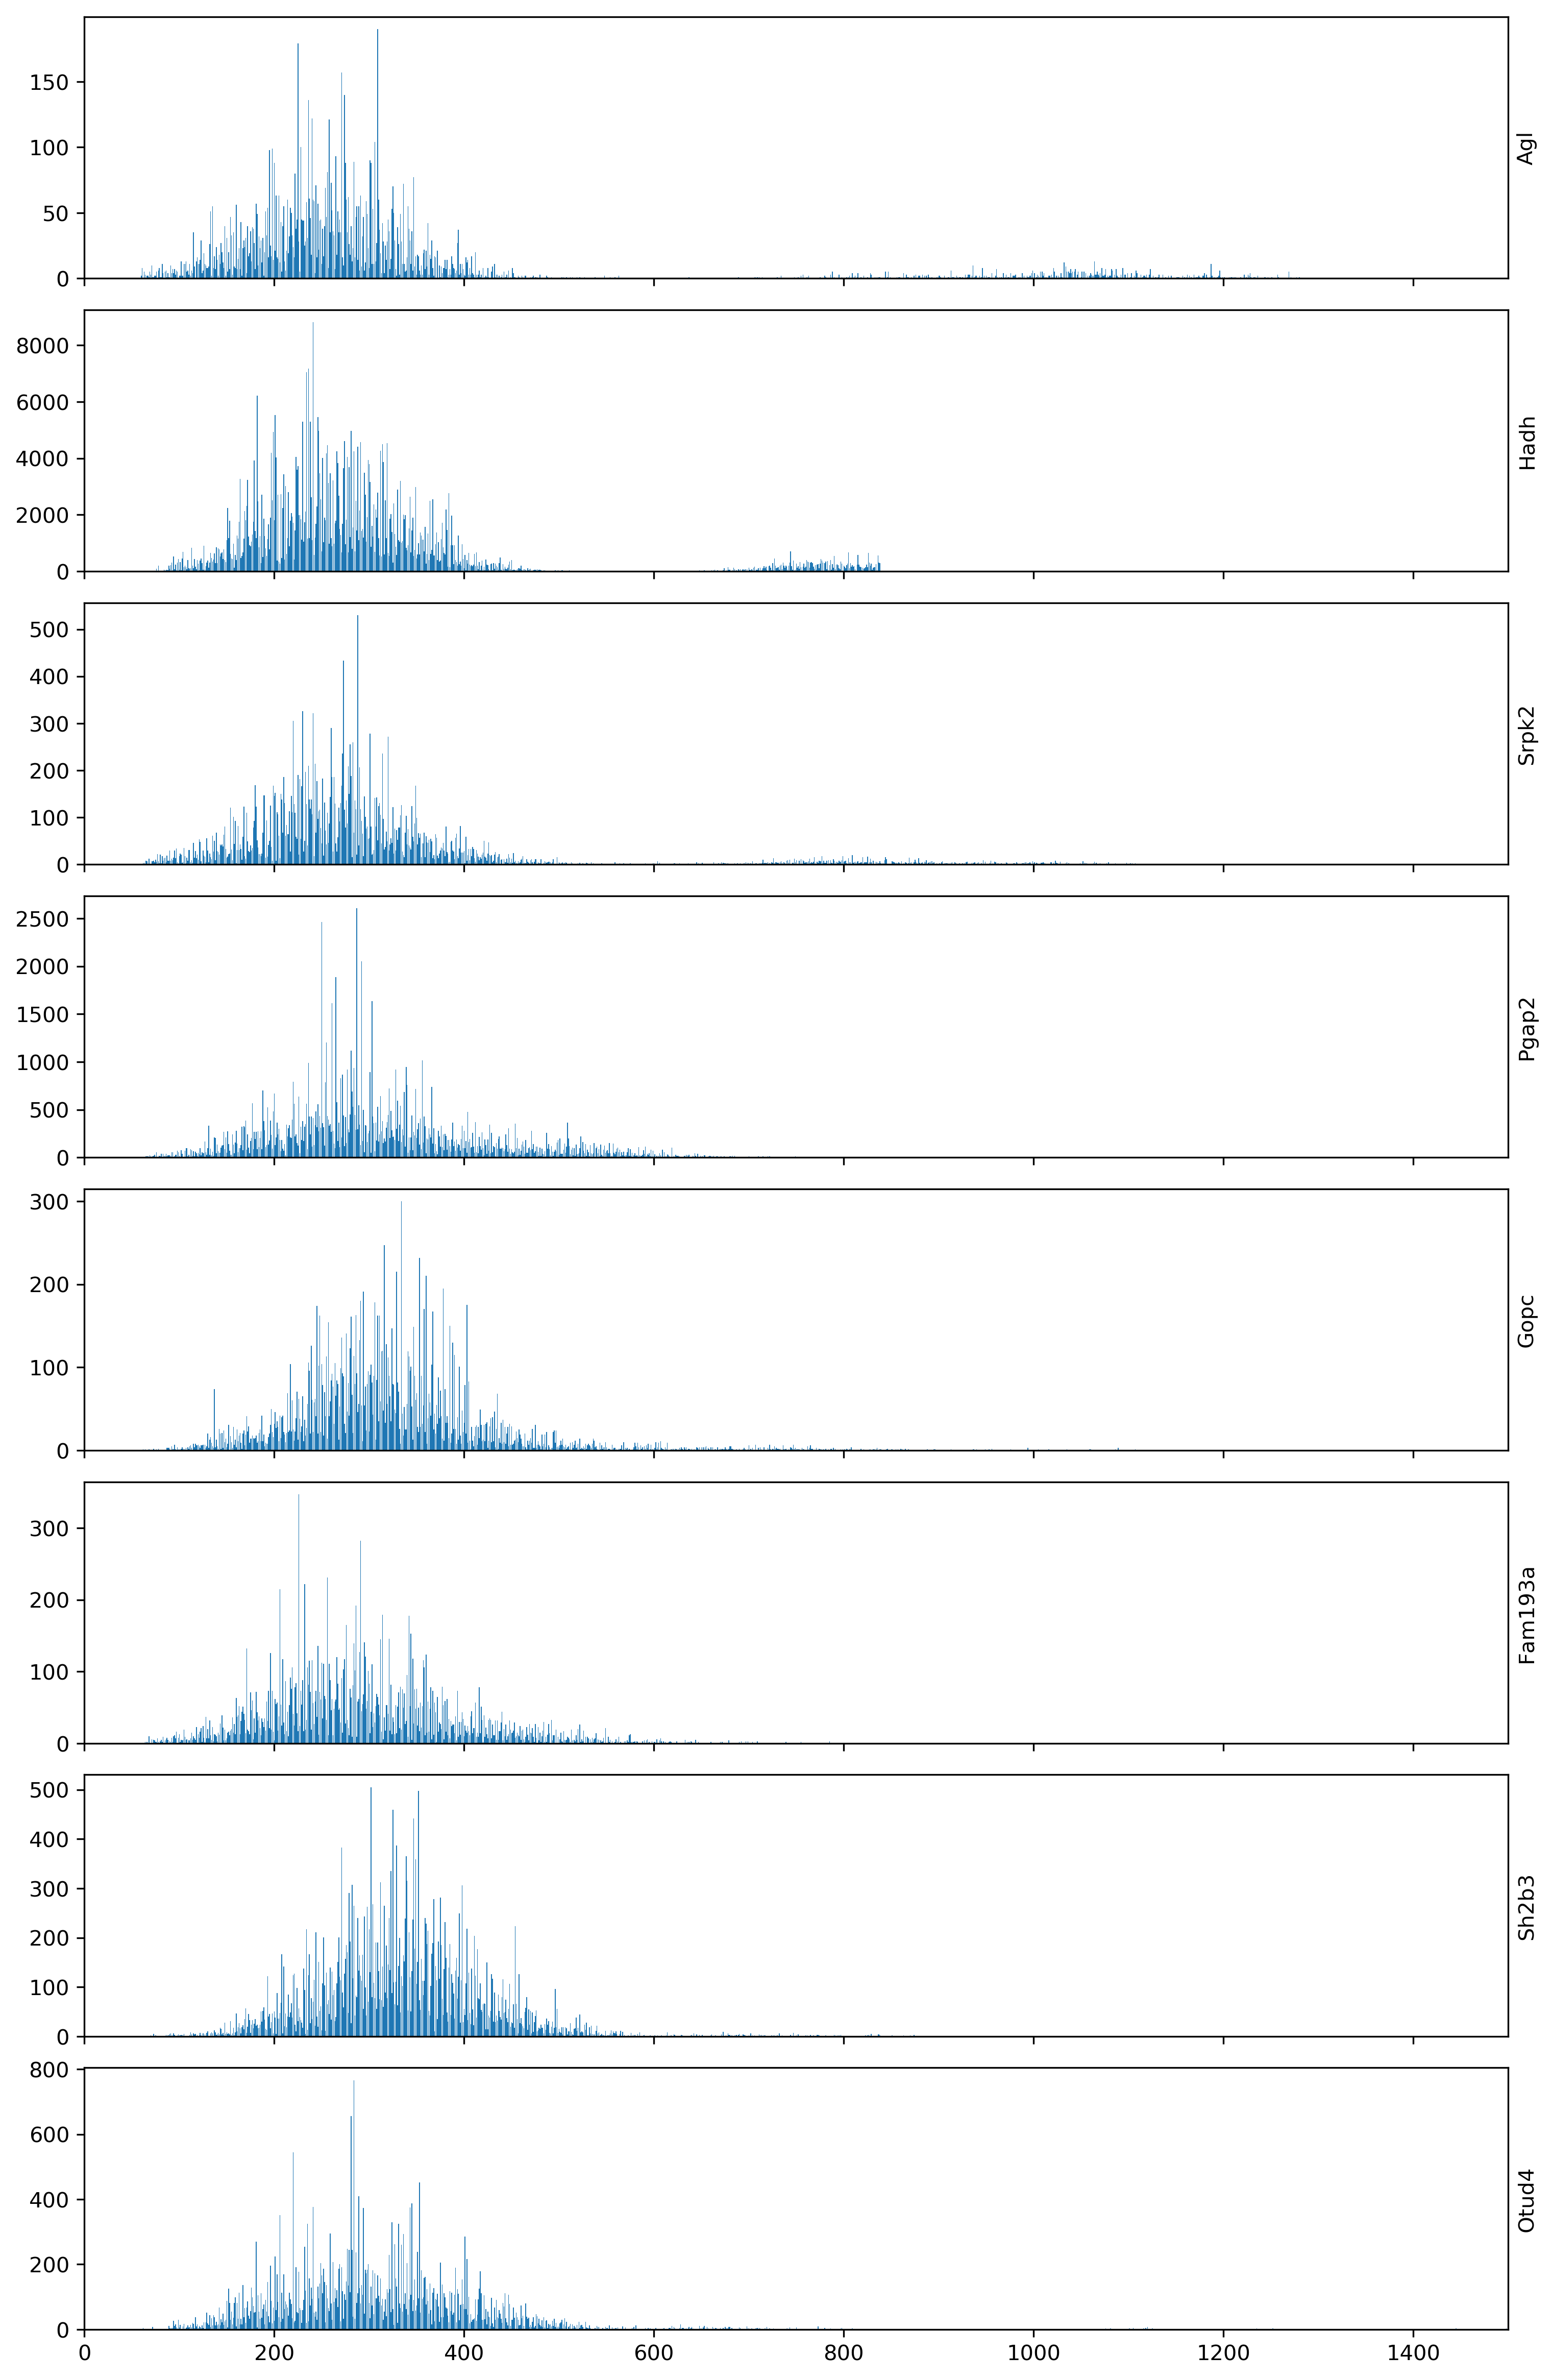

In [12]:
genes = ['Agl', 'Hadh', 'Srpk2', 'Pgap2', 'Gopc', 'Fam193a', 'Sh2b3', 'Otud4']
G = len(genes)

f, axs = plt.subplots(G, figsize=(12, 20), sharex='all')
f.set_dpi(300)
axs[0].set_xlim(left=0, right=1500)

for i in range(G):
    g = genes[i]
    d_gb = data_summary.loc[(data_summary.gene == g), :]
    axs[i].bar(x=d_gb.distance, height=d_gb.counts)
    axs[i].set(ylabel=g)
    axs[i].yaxis.set_label_position("right")

f.subplots_adjust(hspace=0.12)
plt.show()

Inspecting the selected regions in the genome more carefully showed that Agl, Hadh, Srpk2, Pgap2, and Gapc contained potential internal priming locations that could result in generating reads within an 750 nt cutoff.  On this basis, they are removed from any further consideration.  At the same time, Fam193 and Sh2b3 generated reads even as far out as 800 nt and did not have any potential IP sites, therefore, they will be retained, and a cutoff of 800 nt for all genes will be used. That is, genes that did not have at least an 800 nt sampling region will be removed, and any reads beyond 800 nt will be excluded.  The aim of this is to provide more uniformity in the analysis.

In [13]:
# remove genes with clear IP outliers
data_clean = data[-data.gene.isin(['Agl', 'Hadh', 'Srpk2', 'Pgap2', 'Gopc'])]

# restrict to genes with at least 800 width
data_clean = data_clean[data_clean.width >= 800]

# consider only reads up to 800
data_clean = data_clean[data_clean.distance <= 800]

# remove width column (since now everything is 800 width)
data_clean.drop(columns=['width'], inplace=True)

# remove unused gene names
data_clean.gene.cat.remove_unused_categories(inplace=True)

# reindex
data_clean.reset_index(inplace=True, drop=True)

data_clean.head()

,chromosome,position,counts,batch,gene,txEnd,distance
0,chr11,84401150,1,SRR6835844,Acaca,84401664,514
1,chr11,84401159,1,SRR6835844,Acaca,84401664,505
2,chr11,84401160,1,SRR6835844,Acaca,84401664,504
3,chr11,84401176,1,SRR6835844,Acaca,84401664,488
4,chr11,84401188,1,SRR6835844,Acaca,84401664,476


In [14]:
data_clean.to_csv("tmuris.coverage.partial.clean800.tsv.gz", sep='\t', index=False, compression='gzip')

# (Re)Compute Stats

In [15]:
cutoff95_bg = data_clean.groupby(['batch', 'gene']).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))
cutoff95_bg.head()

batch       gene  
SRR6835844  Acaca     393.880000
            Aplp2     379.329730
            Asb6      380.329412
            Bcas3     383.980000
            Bcl2l1    393.916667
dtype: float64

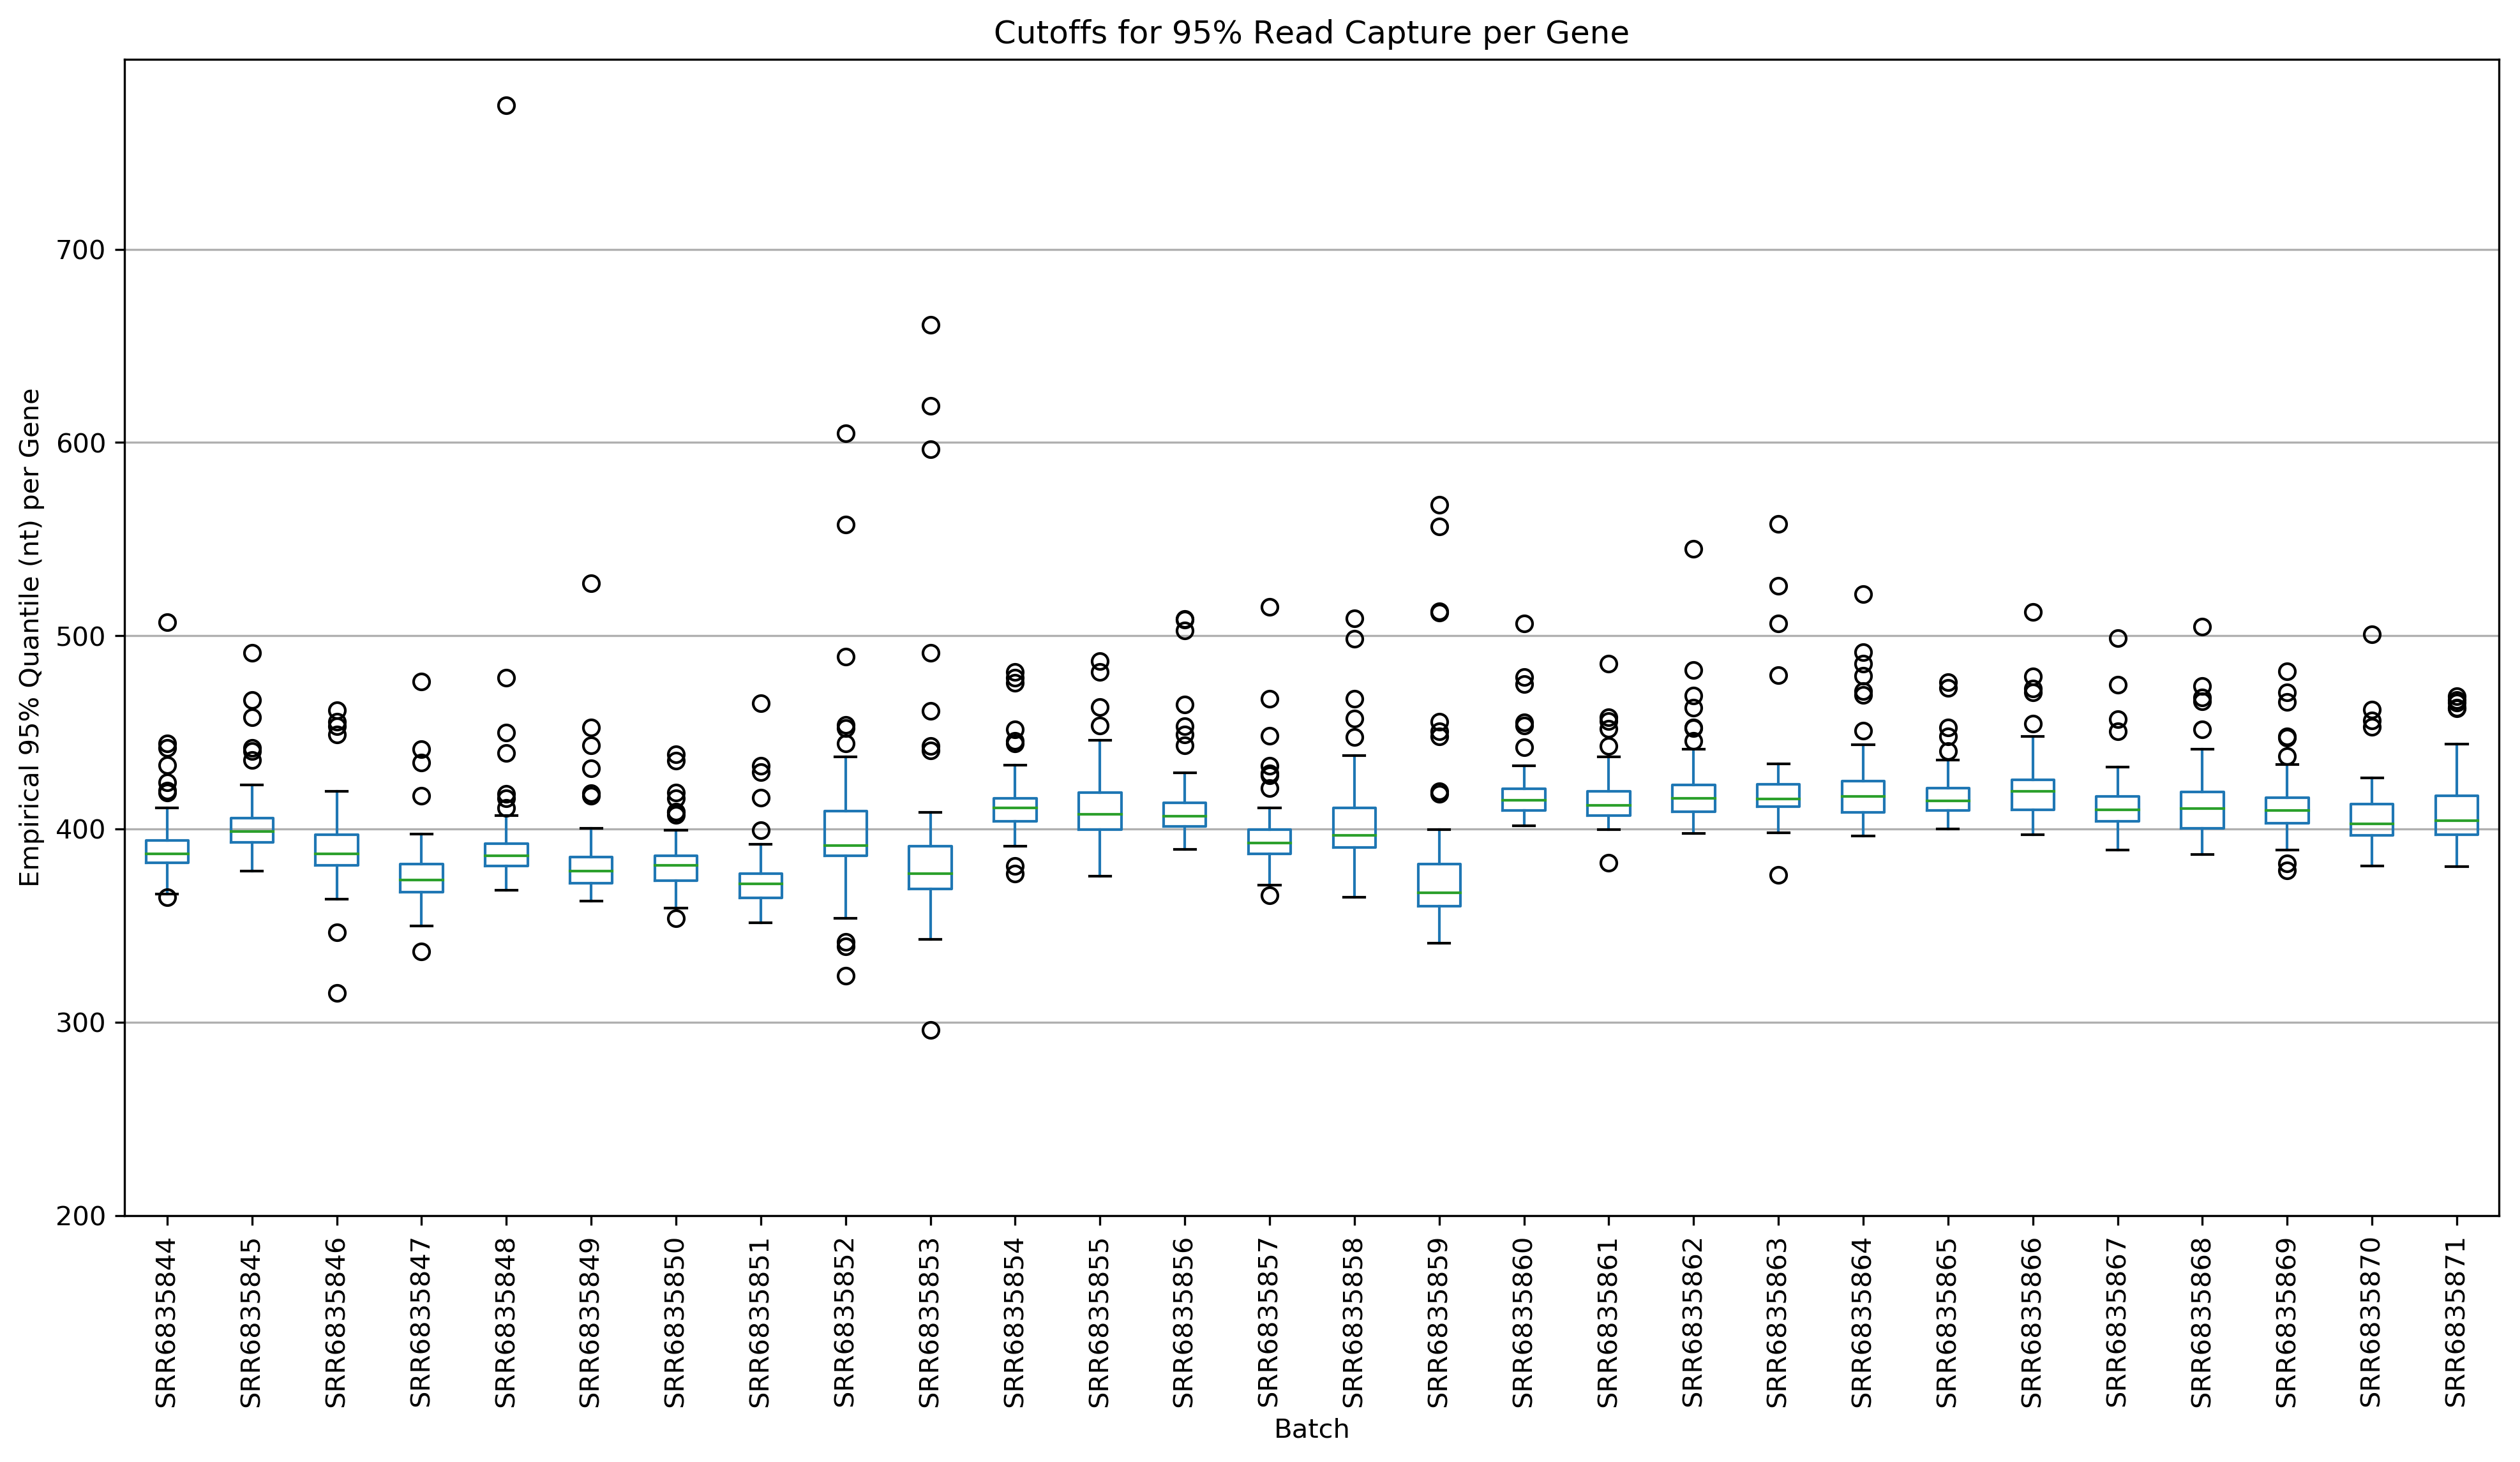

In [16]:
ax = cutoff95_bg.unstack(level=0).plot(kind='box', figsize=(16,8), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,800,100))
plt.grid(True, axis='y')

plt.title("Cutoffs for 95% Read Capture per Gene")
plt.ylabel("Empirical 95% Quantile (nt) per Gene")
plt.xlabel("Batch")
plt.show()

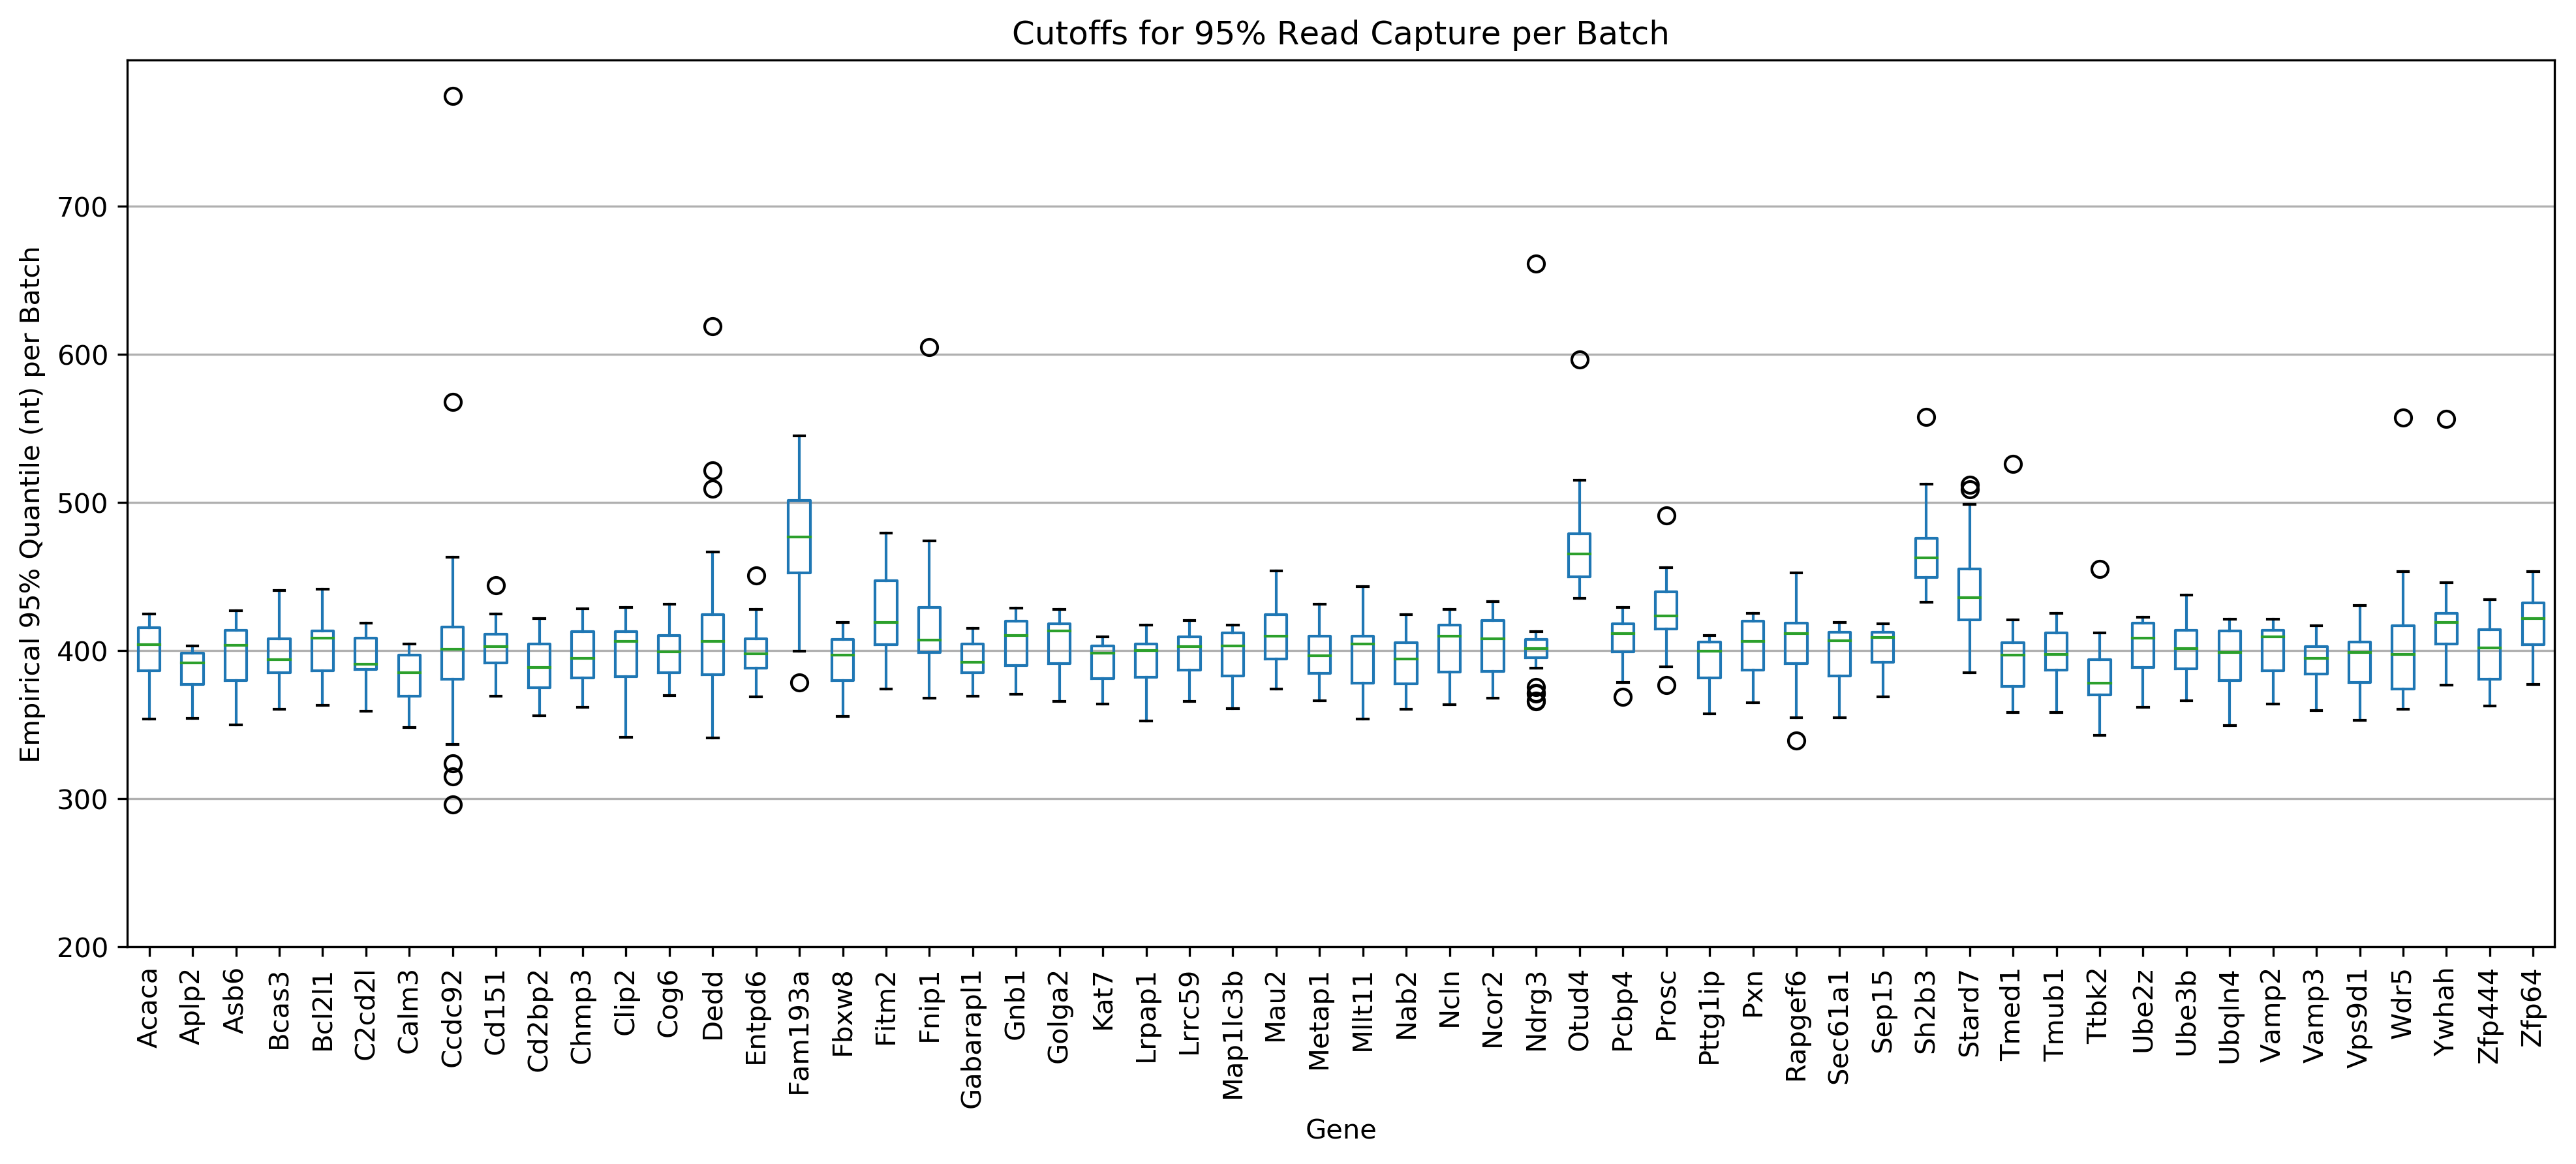

In [17]:
ax = cutoff95_bg.unstack(level=-1).plot(kind='box', figsize=(16,6), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,800,100))
plt.grid(True, axis='y')
plt.title("Cutoffs for 95% Read Capture per Batch")
plt.ylabel("Empirical 95% Quantile (nt) per Batch")
plt.xlabel("Gene")
plt.show()

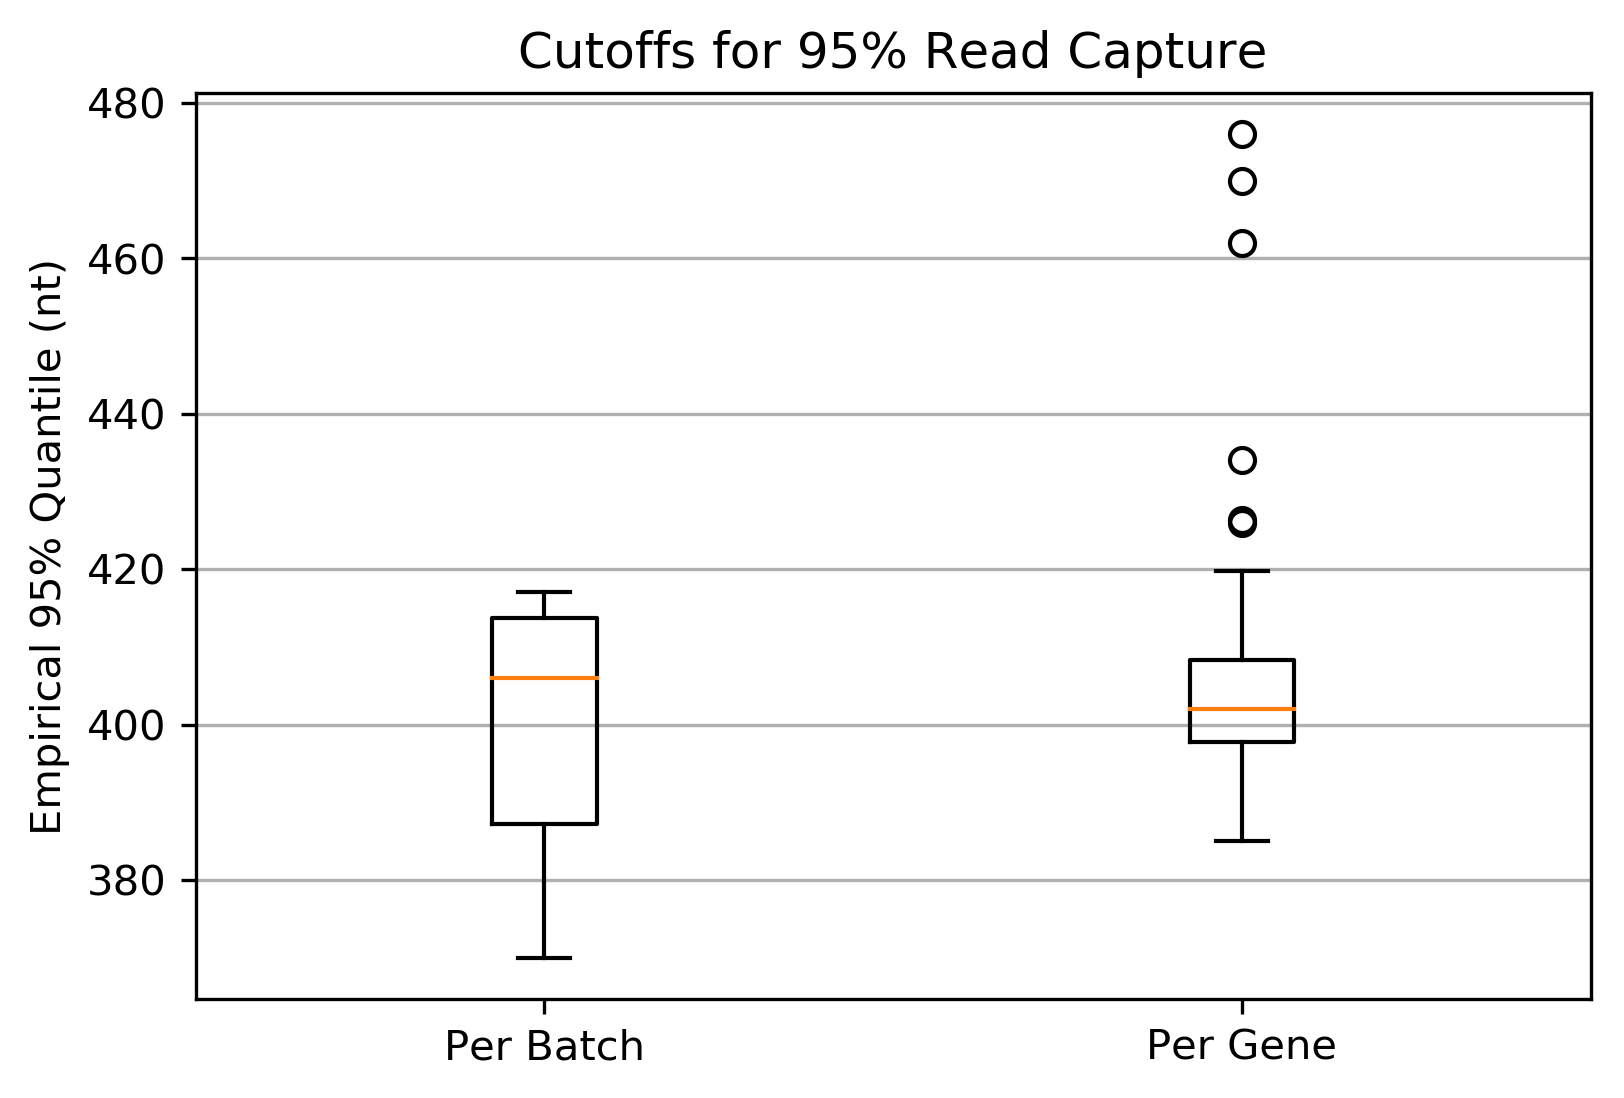

In [18]:
cutoff95_b = data_clean.groupby(['batch'], as_index=False).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))
cutoff95_g = data_clean.groupby(['gene'], as_index=False).apply(lambda g: weighted_quantile(g['distance'], 0.95, g['counts']))

plt.figure(figsize=(6,4), dpi=300)
plt.boxplot([cutoff95_b, cutoff95_g], labels=['Per Batch', 'Per Gene'])
plt.grid(True, axis='y')
plt.title("Cutoffs for 95% Read Capture")
plt.ylabel("Empirical 95% Quantile (nt)")
plt.show()

## 99% Capture Rates

In [19]:
cutoff99_bg = data_clean.groupby(['batch', 'gene']).apply(lambda g: weighted_quantile(g['distance'], 0.99, g['counts']))
cutoff99_bg.head()

batch       gene  
SRR6835844  Acaca     438.760000
            Aplp2     437.376000
            Asb6      434.160000
            Bcas3     458.360000
            Bcl2l1    472.866667
dtype: float64

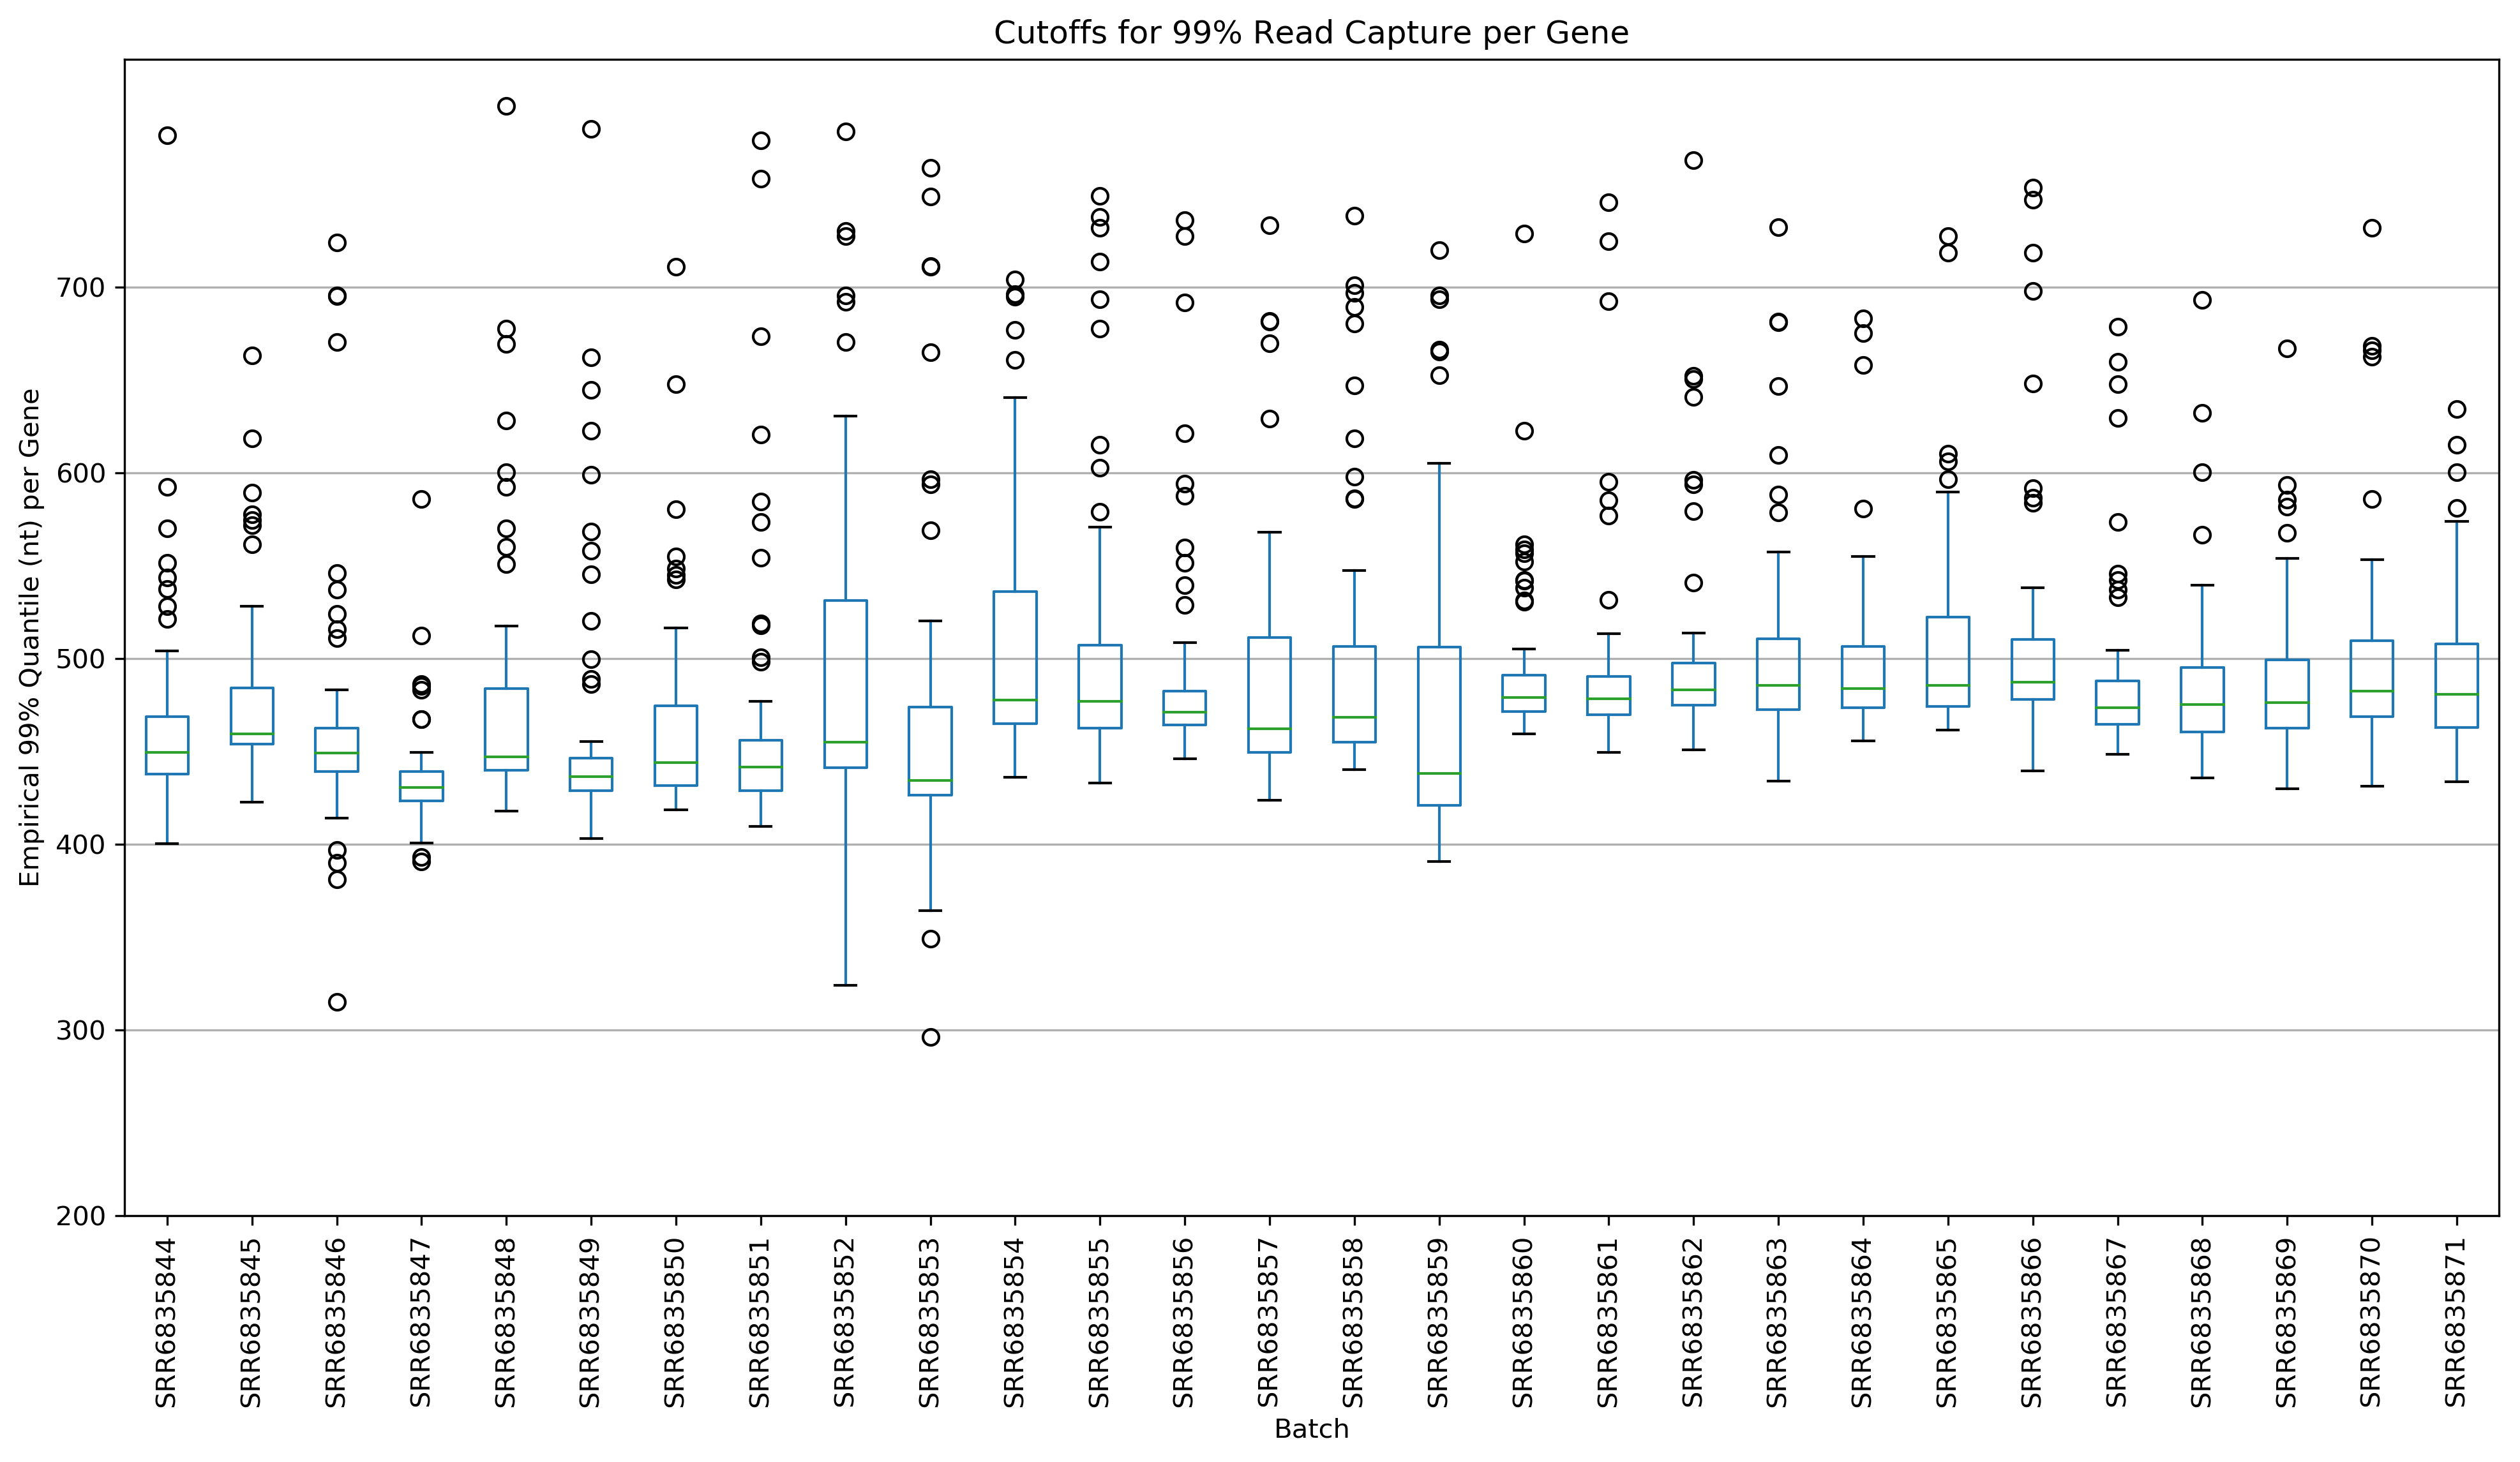

In [20]:
ax = cutoff99_bg.unstack(level=0).plot(kind='box', figsize=(16,8), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,800,100))
plt.grid(True, axis='y')

plt.title("Cutoffs for 99% Read Capture per Gene")
plt.ylabel("Empirical 99% Quantile (nt) per Gene")
plt.xlabel("Batch")
plt.show()

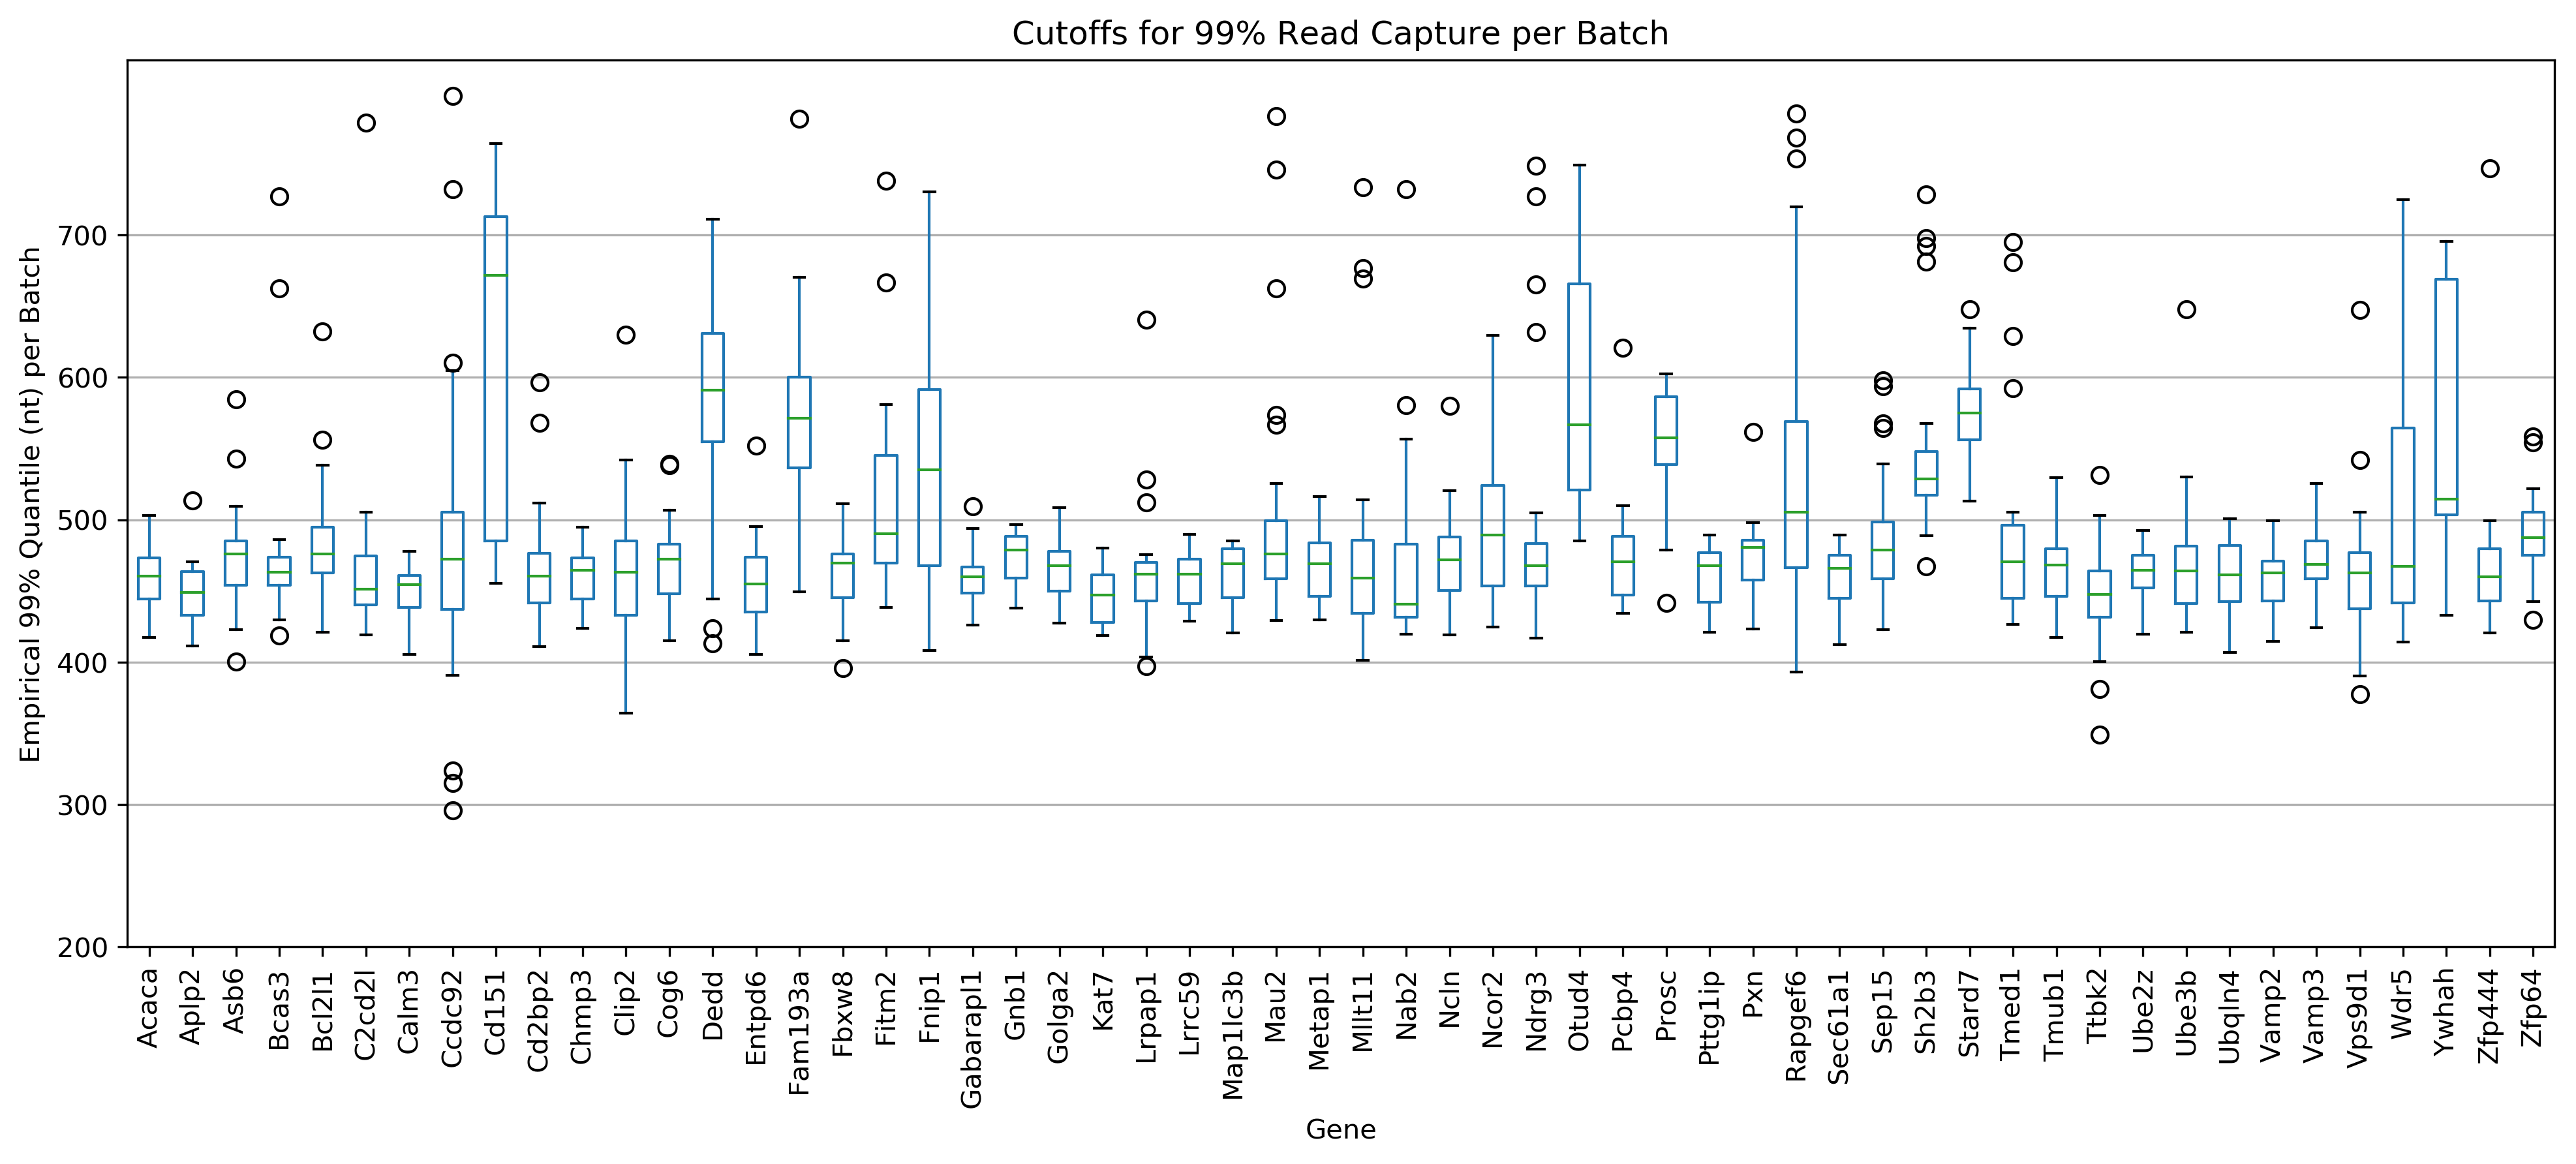

In [21]:
ax = cutoff99_bg.unstack(level=-1).plot(kind='box', figsize=(16,6), rot=90)
ax.figure.set_dpi(300)
plt.yticks(np.arange(200,800,100))
plt.grid(True, axis='y')
plt.title("Cutoffs for 99% Read Capture per Batch")
plt.ylabel("Empirical 99% Quantile (nt) per Batch")
plt.xlabel("Gene")
plt.show()

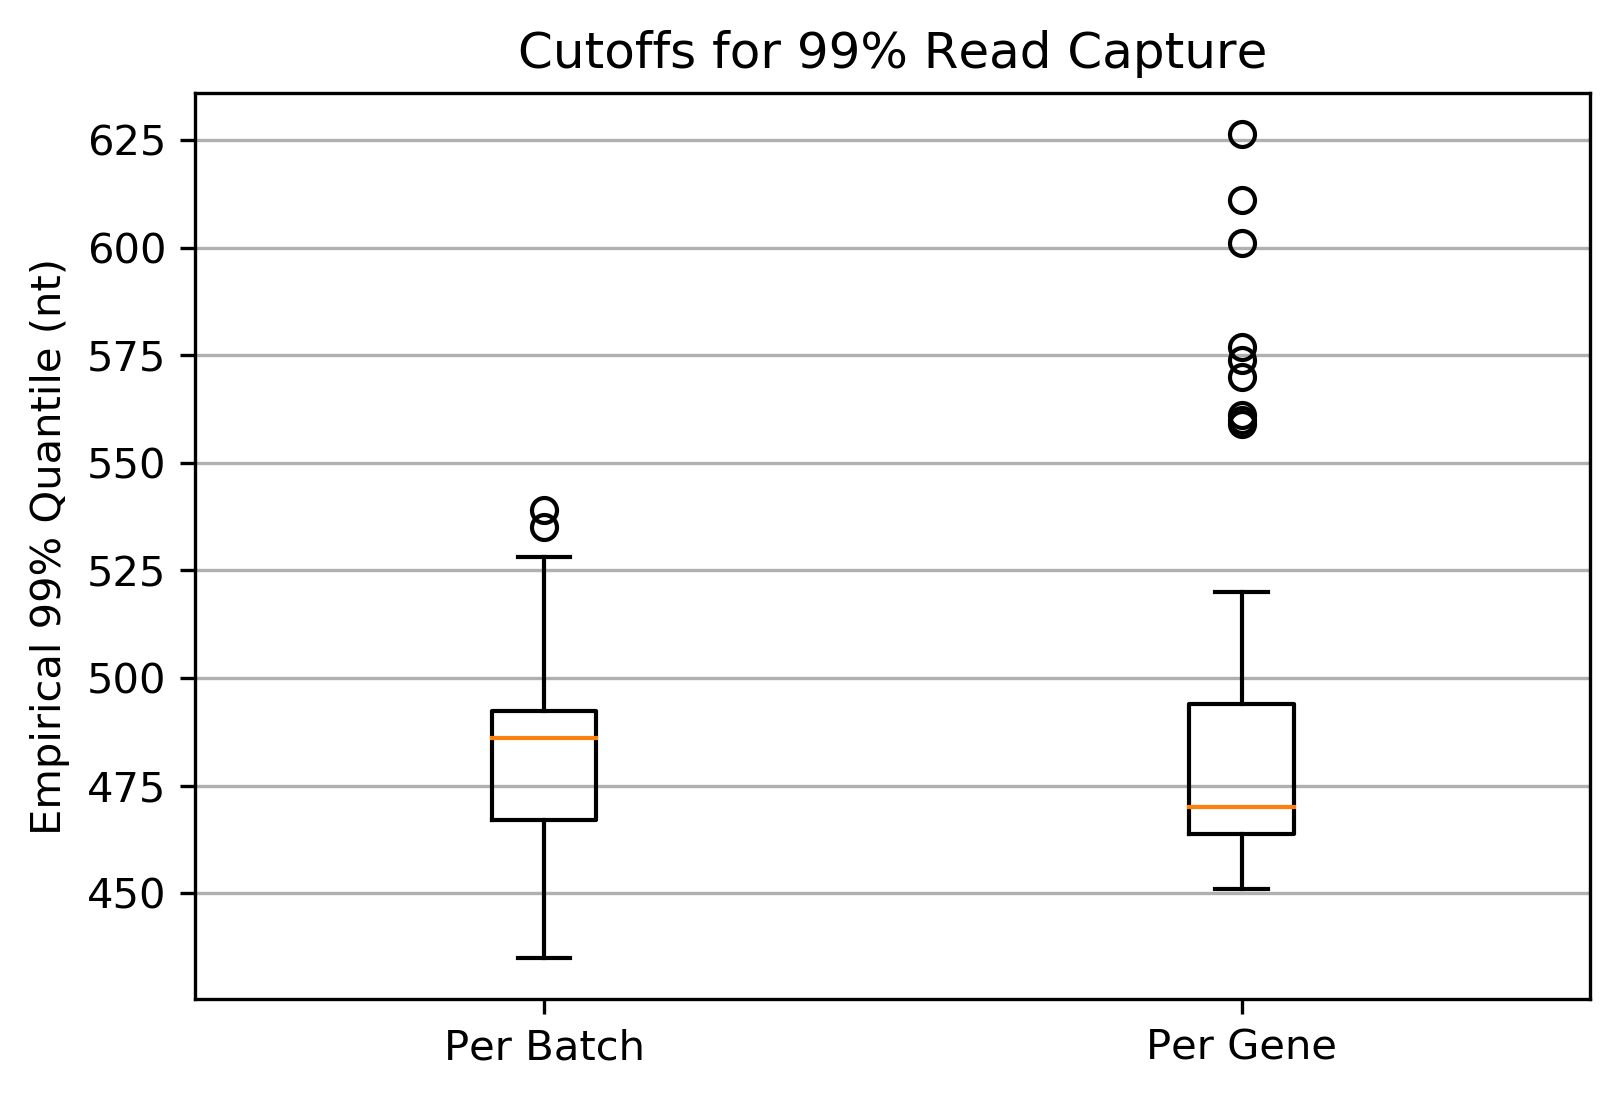

In [22]:
cutoff99_b = data_clean.groupby(['batch'], as_index=False).apply(lambda g: weighted_quantile(g['distance'], 0.99, g['counts']))
cutoff99_g = data_clean.groupby(['gene'], as_index=False).apply(lambda g: weighted_quantile(g['distance'], 0.99, g['counts']))

plt.figure(figsize=(6,4), dpi=300)
plt.boxplot([cutoff99_b, cutoff99_g], labels=['Per Batch', 'Per Gene'])
plt.grid(True, axis='y')
plt.title("Cutoffs for 99% Read Capture")
plt.ylabel("Empirical 99% Quantile (nt)")
plt.show()